In [1]:
import matplotlib.pyplot as plt # for plotting maps
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
from functools import reduce
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict

from IPython.display import clear_output

%matplotlib inline

pd.set_option("display.max_rows", 150)
pd.set_option("display.max_columns", 150)
plt.rcParams.update({'figure.max_open_warning': 0})

DATA_PATH = "raw-from-source/"
CRS = 3857

/Users/SamSpinner/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


### **General Summary**

-------

#### VEST Data

VESTs dataset uses IA's 2018 Election Results and Precinct Boundaries for it's shapefile. 

VEST data files include:  

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  **ia_2018.shp** which has both election results and shapefiles, can be found at [this link](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/UBKYRU/CVWIH1). 



The following counties used shapefiles sourced from the respective county governments instead: Dallas, Johnson, Linn, Story. 

The following precincts were merged to match the 2018 election reports:

1. Appanoose: Udell/Union
2. Black Hawk: Cedar Falls W2P2/Cedar Falls Twp
3. Des Moines: Burlington 1/Tama, Burlington 8/Concordia
4. Fremont: Hamburg/Washington, Farragut/Shenandoah1
5. Lee: Fort Madison 4A/4B, Keokuk 2A/2B, FCM/Harrison
6. Polk: Grimes 2/Urbandale 12
7. Tama: Toledo 1/2/3

The election data columns reported are:

<font color="Coral">
    

Secretary of State
    
    1. G18SOSRPAT - Paul D. Pate (Republican Party)
    2. G18SOSDDEJ - Deidre DeJear (Democratic Party)
    3. G18SOSLOFE - Jules Ofenbakh (Libertarian Party)
    4. G18SOSOWRI - Write-in Votes
    
Governor
    
    1. G18GOVRREY - Kim Reynolds (Republican Party)   
    2. G18GOVDHUB - Fred Hubbell (Democratic Party)
    3. G18GOVLPOR - Jake Porter (Libertarian Party)
    4. G18GOVOSIE - Gary Siegwarth (Clear Water Party)
    5. G18GOVOWRI - Write-in Votes
    
Attorney General
    
    1. G18ATGDMIL - Tom Miller (Democratic Party)
    2. G18ATGLBAT - Marco Battaglia (Libertarian Party)
    3. G18ATGOWRI - Write-in Votes

Treasurer
    
    1. G18TRERDAV - Jeremy N. Davis (Republican Party)
    2. G18TREDFIT - Michael L. Fitzgerald (Democratic Party)
    3. G18TRELHIR - Timothy Hird (Libertarian Party)
    4. G18TREOWRI - Write-in Votes

    
Auditor
    
    1. G18AUDRMOS - Mary Mosiman (Republican Party)
    2. G18AUDDSAN - Rob Sand (Democratic Party)
    3. G18AUDLPER - Fred Perryman (Libertarian Party)
    4. G18AUDOWRI - Write-in Votes
    

Agriculture Secretary
    
    1. G18AGRRNAI - Mike Naig (Republican Party)
    2. G18AGRDGAN - Tim Gannon (Democratic Party)
    3. G18AGRLSTE - Rick Stewart (Libertarian Party)
    4. G18AGROWRI - Write-in Votes

</font>
 

----------------

#### Raw shapefile data

VEST reportedly collected shapefile data from the [IA Secretary of State](https://www.sos.IA.gov/elections/research/election-results-and-voters-pamphlets.aspx). 

SoS shapefile data for IA found [here](https://sos.iowa.gov/shapefiles/Statewide%20Precinct%20Layer/). 

The IA Secretary of State's data files include: 

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  **Precincts041714.sbx** which contains shapefiles for precincts and counties that mostly align with the election results data.

County shapefiles for [Dallas](http://geodallas.dallascountyiowa.gov/SpatialDownload/Default.aspx), [Johnson](https://www.iowagisdata.org/index.php/apps/files/?dir=/County/Johnson/Open&fileid=854), and [Linn](https://opendata-linncounty-gis.opendata.arcgis.com/datasets/voting-precinct-split-1?geometry=-92.535%2C41.808%2C-90.777%2C42.165) county were taken directly from county websites, in accordance with VEST's process. Data not posted on county websites was generally found on [Iowa's GIS Hub](https://www.iowagisdata.org/). 

For Story county, [GIS coordinator](https://www.storycountyiowa.gov/Directory.aspx?did=31) Matt Boeck was contacted directly and provided precinct level data via email. 

The following counties were revised to reflect updated municipal boundaries using shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release: Dubuque, Marion, Muscatine, Polk, Pottawattamie, Scott.

These counties were downloaded using this [link](https://www.census.gov/geo/partnerships/pvs/partnership19v2/st19_ia.html).

-------

#### Raw election results data

Most election results were pulled from [this statewide election data site](https://results.vote.IA.gov/), county by county. The data was stored in a deprecated .xls format that needed to be processed and joined semi-manually. The work for this can be found in  **VEST-ia-2018-data-accumulation.ipynb**, present in this repo.
   

-----

All of the data IAs accessed and downloaded between the dates of March 23rd and March 30th, 2021. 


#### <font color="red">Attention:</font>
RDH was not able to validate the precincts in all counties, specifically, Linn, Dubuque, Story, and Polk county had too many unregistered modifications for us to edit. VEST's precinct shapefiles for those counties could very well be correct, but we had no way of verifying. We can verify that the vote totals for these counties' precincts, and all precincts for that matter, are correct. 

#### Upload, modify, and analyze bulk of data. 

In [2]:
master_vest_df = gp.read_file(DATA_PATH + "vest_data/ia_2018.shp")
master_sos_df = pd.read_csv(DATA_PATH + "SoS_processed_election_final.csv")
master_shape_df = gp.read_file(DATA_PATH + "SoS_shapefiles/Precincts041714.shp")

In [3]:
vest_df = master_vest_df.copy().to_crs(CRS)
sos_df = master_sos_df.copy()
shape_df = master_shape_df.copy().to_crs(CRS)

sos_df["County"] = sos_df["County"].str.replace("_", " ")
sos_df["County"] = sos_df["County"].str.replace("'", "")

obrien_fix = {"OBrien" : "Obrien"}
def fix_obrien(val):
    if val in obrien_fix:
        return obrien_fix[val]
    return val

sos_df["County"] = sos_df["County"].apply(fix_obrien)

In [4]:
shape_df.head()

,OBJECTID,OBJECTID_1,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,IDEAL_VALU,DEVIATION,House_Dist,Senate_Dis,Congressio,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,1,1,6.0,35.873722,DICKINSON6,1.0,None,Dickinson 6,576.0,1.0,575.0,2.0,1,4,0.411027,0.411027,0.010325,"POLYGON ((-10565776.479 5364090.501, -10565776..."
1,2,2,7.0,29.885220,DICKINSON7,1.0,None,Dickinson 7,212.0,1.0,211.0,2.0,1,4,0.462693,0.462693,0.008601,"POLYGON ((-10579008.805 5350912.808, -10579752..."
2,3,3,8.0,29.847010,DICKINSON8,1.0,None,Dickinson 8,3366.0,1.0,3365.0,2.0,1,4,0.589906,0.589906,0.008592,"POLYGON ((-10592076.266 5350939.403, -10592929..."
3,4,4,9.0,48.195625,DICKINSON9,1.0,None,Dicksinon 9,162.0,1.0,161.0,2.0,1,4,0.535877,0.535877,0.013872,"POLYGON ((-10600549.571 5364242.648, -10600550..."
4,5,5,2.0,71.427567,LAFR,1.0,None,Lake/Freeman,595.0,1.0,594.0,2.0,1,4,0.582407,0.582407,0.020525,"POLYGON ((-10579008.805 5350912.808, -10577870..."


<AxesSubplot:>

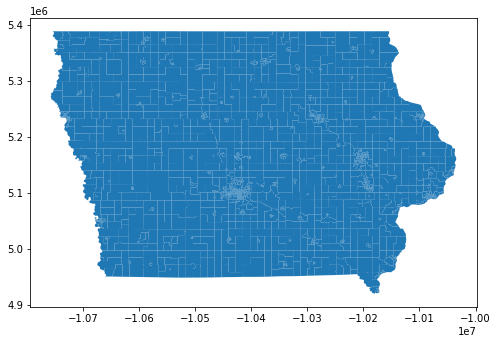

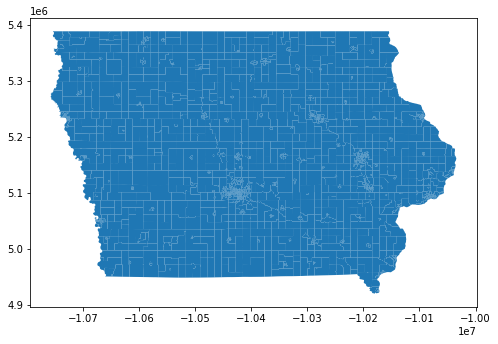

In [5]:
vest_df.plot(figsize=(8,8))
shape_df.plot(figsize=(8,8))

##### Precinct names within each county are quite different between the raw SoS election data and both VEST and shapefile data. 

##### Addidionally, precinct names are not unique in the SoS or VEST files, so we will need to create a unique ID by combining county and precinct name. 

##### So, first we will validate vote counts of each county, and using those results, will construct a dataframe that maps SoS precinct names to VEST precinct names. 

##### The general vote validation process is:
1. Filter by county.
2. Find row sums of votes. 
3. Sort by row sums. (there is only one case of a duplicate sum, in Black Hawk county)
4. Profit. 

In [6]:
validated_counties = set()
remaining_counties = set()

election_name_df = pd.DataFrame(columns=["SoS Name", "VEST Name", "County"])

all_counties = vest_df["COUNTY"].unique()

# we will want a way to construct mappings from shapefile precincts
# to VEST names and counties

for county in all_counties:
    v = vest_df[vest_df["COUNTY"] == county]
    s = sos_df[sos_df["County"] == county]
    
    # Reset indexes
    v.index = [i for i in range(len(v))]
    s.index = [i for i in range(len(s))]
    
    # Save precinct names so we can convert for the merge
    new_names = v["NAME"]
    old_names = s["Precinct"]
    
    # Isolate vote counts in each dataframe
    votes_v = v.iloc[:, 3:-1].dropna().astype('int')
    votes_s = s.iloc[:, 2:-1].dropna().astype('int')
    
    
    # Not foolproof, but used to sort rows, we hope that there
    # are no duplicate row sums
    votes_v["Row Sum"] = votes_v.sum(axis=1)
    votes_s["Row Sum"] = votes_s.sum(axis=1)
    
    
    votes_v.sort_values(by="Row Sum", inplace=True)
    votes_s.sort_values(by="Row Sum", inplace=True)
    
    changed_new = new_names.iloc[votes_v.index]
    changed_old = old_names.iloc[votes_s.index]

    changed_new.index = [i for i in range(len(changed_new))]
    changed_old.index = [i for i in range(len(changed_old))]
    
    votes_v.index = [i for i in range(len(votes_v))]
    votes_s.index = [i for i in range(len(votes_s))]
    
    # If these two have the same value, we want to do the following work
    if votes_s.equals(votes_v):
        
        temp = pd.DataFrame(data = {"SoS Name" : changed_old, "VEST Name" : changed_new})
        temp["County"] = county
        election_name_df = pd.concat([election_name_df, temp], axis=0)
        
        validated_counties.add(county)
        
    else:
        remaining_counties.add(county)
        
    
election_name_df.to_csv("precinct_name_conversion.csv")

In [7]:
print(remaining_counties)

{'Black Hawk'}


##### Black Hawk was the only county with a duplicate row sum that resulted in a difference in sorting rows. Will correct manually here to complete election_name_df for old to new precinct name conversion

In [8]:
# Black Hawk
election_name_df = election_name_df[election_name_df["County"] != "Black Hawk"]

v = vest_df[vest_df["COUNTY"] == "Black Hawk"]
s = sos_df[sos_df["County"] == "Black Hawk"]

# Reset indexes
v.index = [i for i in range(len(v))]
s.index = [i for i in range(len(s))]


# Isolate vote counts in each dataframe
votes_v = v.iloc[:, 2:-1].dropna()
votes_s = s.iloc[:, 1:-1].dropna()

votes_v["Row Sum"] = votes_v.sum(axis=1)
votes_s["Row Sum"] = votes_s.sum(axis=1)

votes_v.sort_values(by="Row Sum", inplace=True)
votes_s.sort_values(by="Row Sum", inplace=True)

changed_new.index = [i for i in range(len(changed_new))]
changed_old.index = [i for i in range(len(changed_old))]

votes_v.index = [i for i in range(len(votes_v))]
votes_s.index = [i for i in range(len(votes_s))]

# There is a duplicate row sum, at index 46 and 47
new_idxs = [i for i in range(len(votes_v))]
new_idxs[46] = 47
new_idxs[47] = 46

votes_v = votes_v.iloc[new_idxs]
votes_v.index = [i for i in range(len(votes_v))]

changed_new = votes_v["NAME"]
changed_old = votes_s["Precinct"]

votes_v.drop(columns=["NAME"], inplace=True)
votes_s.drop(columns=["Precinct"], inplace=True)


assert(votes_v.astype('int').equals(votes_s.astype('int')))

temp = pd.DataFrame(data = {"SoS Name" : changed_old, "VEST Name" : changed_new})
temp["County"] = "Black Hawk"
election_name_df = pd.concat([election_name_df, temp], axis=0)
election_name_df.to_csv("election_precinct_name_conversion.csv")

#### Join election results to dataframe with unique ID. 

In [9]:
election_name_df["ELECTION_MERGE_ID"] = election_name_df["County"] + " " + election_name_df["SoS Name"]
election_name_df["SHAPE_MERGE_ID"] = election_name_df["County"] + " " + election_name_df["VEST Name"]

sos_df["ELECTION_MERGE_ID"] = sos_df["County"] + " " + sos_df["Precinct"]

In [10]:
print("How many sos elections results don't have a precinct name to merge to?")
print(len(sos_df[~sos_df["ELECTION_MERGE_ID"].isin(election_name_df["ELECTION_MERGE_ID"])]))

print("How many sos elections results don't have a precinct name to merge to?")
print(len(sos_df[~sos_df["ELECTION_MERGE_ID"].isin(election_name_df["ELECTION_MERGE_ID"])]))

How many sos elections results don't have a precinct name to merge to?
0
How many sos elections results don't have a precinct name to merge to?
0


In [11]:
display(election_name_df.head())
display(sos_df.head())

,SoS Name,VEST Name,County,ELECTION_MERGE_ID,SHAPE_MERGE_ID
0,Precinct No. 9 - NS Ballot #1,Dicksinon 9,Dickinson,Dickinson Precinct No. 9 - NS Ballot #1,Dickinson Dicksinon 9
1,Precinct No. 7,Dickinson 7,Dickinson,Dickinson Precinct No. 7,Dickinson Dickinson 7
2,Precinct No. 4 - NS Ballot #1,Dickinson 4,Dickinson,Dickinson Precinct No. 4 - NS Ballot #1,Dickinson Dickinson 4
3,Precinct No. 6 - NS Ballot #1,Dickinson 6,Dickinson,Dickinson Precinct No. 6 - NS Ballot #1,Dickinson Dickinson 6
4,Precinct No. 14 - S Ballot #1,Dickinson 14 - Spirit Lake West,Dickinson,Dickinson Precinct No. 14 - S Ballot #1,Dickinson Dickinson 14 - Spirit Lake West


,Unnamed: 0,Precinct,G18GOVRREY,G18GOVDHUB,G18GOVLPOR,G18GOVOSIE,G18GOVOWRI,G18ATGDMIL,G18ATGLBAT,G18ATGOWRI,G18SOSRPAT,G18SOSDDEJ,G18SOSLOFE,G18SOSOWRI,G18TRERDAV,G18TREDFIT,G18TRELHIR,G18TREOWRI,G18AUDRMOS,G18AUDDSAN,G18AUDLPER,G18AUDOWRI,G18AGRRNAI,G18AGRDGAN,G18AGRLSTE,G18AGROWRI,County,ELECTION_MERGE_ID
0,0,Geneva / Ingham / East Mott,217,95,4,2,0,205,59,1,213,86,6,0,176,127,1,1,193,107,2,0,209,92,5,0,Franklin,Franklin Geneva / Ingham / East Mott
1,1,Grant / Osceola,186,67,3,1,0,158,50,3,185,62,3,0,161,89,3,0,168,80,2,0,189,61,4,0,Franklin,Franklin Grant / Osceola
2,2,Hamilton / Lee / Reeve,205,84,4,2,0,175,71,1,214,74,2,0,182,103,5,0,189,92,7,0,210,73,6,0,Franklin,Franklin Hamilton / Lee / Reeve
3,3,Hampton 1,153,119,8,0,0,201,49,0,146,117,8,0,116,145,9,0,124,136,11,0,138,120,15,0,Franklin,Franklin Hampton 1
4,4,Hampton 2,227,146,10,2,0,257,71,3,227,139,9,0,187,177,6,0,203,163,11,0,232,132,13,0,Franklin,Franklin Hampton 2


In [12]:
combined_election_results = election_name_df.merge(sos_df, on="ELECTION_MERGE_ID", how="inner")
combined_election_results.head()

,SoS Name,VEST Name,County_x,ELECTION_MERGE_ID,SHAPE_MERGE_ID,Unnamed: 0,Precinct,G18GOVRREY,G18GOVDHUB,G18GOVLPOR,G18GOVOSIE,G18GOVOWRI,G18ATGDMIL,G18ATGLBAT,G18ATGOWRI,G18SOSRPAT,G18SOSDDEJ,G18SOSLOFE,G18SOSOWRI,G18TRERDAV,G18TREDFIT,G18TRELHIR,G18TREOWRI,G18AUDRMOS,G18AUDDSAN,G18AUDLPER,G18AUDOWRI,G18AGRRNAI,G18AGRDGAN,G18AGRLSTE,G18AGROWRI,County_y
0,Precinct No. 9 - NS Ballot #1,Dicksinon 9,Dickinson,Dickinson Precinct No. 9 - NS Ballot #1,Dickinson Dicksinon 9,8,Precinct No. 9 - NS Ballot #1,57,17,0,1,0,46,11,0,59,15,0,0,45,27,0,1,48,23,0,1,62,12,1,0,Dickinson
1,Precinct No. 7,Dickinson 7,Dickinson,Dickinson Precinct No. 7,Dickinson Dickinson 7,6,Precinct No. 7,62,33,5,0,0,59,24,1,63,35,1,0,51,44,2,0,57,39,1,0,74,24,2,0,Dickinson
2,Precinct No. 4 - NS Ballot #1,Dickinson 4,Dickinson,Dickinson Precinct No. 4 - NS Ballot #1,Dickinson Dickinson 4,3,Precinct No. 4 - NS Ballot #1,119,86,3,1,0,133,34,1,127,78,1,0,103,98,0,0,106,95,5,0,129,75,3,0,Dickinson
3,Precinct No. 6 - NS Ballot #1,Dickinson 6,Dickinson,Dickinson Precinct No. 6 - NS Ballot #1,Dickinson Dickinson 6,5,Precinct No. 6 - NS Ballot #1,139,83,2,4,0,143,43,3,139,82,5,0,114,106,5,0,118,105,5,0,149,76,4,0,Dickinson
4,Precinct No. 14 - S Ballot #1,Dickinson 14 - Spirit Lake West,Dickinson,Dickinson Precinct No. 14 - S Ballot #1,Dickinson Dickinson 14 - Spirit Lake West,13,Precinct No. 14 - S Ballot #1,243,166,5,2,0,267,71,3,248,156,1,0,219,188,6,0,228,178,5,0,254,151,5,0,Dickinson


### Now, let's look at shapefile data. This is going to be a bit more involved. 

#### First, validate all counties that weren't pulled from the county's data repo or the updated census bureau and had no special merges. 

#### Then, validate the 4 county shapefiles where VEST got the shapefile data directly from the county. 

#### Finally, validate the counties that were drawn using updated census data or had precinct merges performed. 



#### Ultimately, we are unable to validate shapefile data for Polk, Scott, Dubuque, and Linn counties. That work can be found at the bottom of the notebook. 

In [13]:
display(vest_df.head())
display(shape_df.head())

,COUNTY,DISTRICT,NAME,G18GOVRREY,G18GOVDHUB,G18GOVLPOR,G18GOVOSIE,G18GOVOWRI,G18ATGDMIL,G18ATGLBAT,G18ATGOWRI,G18SOSRPAT,G18SOSDDEJ,G18SOSLOFE,G18SOSOWRI,G18TRERDAV,G18TREDFIT,G18TRELHIR,G18TREOWRI,G18AUDRMOS,G18AUDDSAN,G18AUDLPER,G18AUDOWRI,G18AGRRNAI,G18AGRDGAN,G18AGRLSTE,G18AGROWRI,geometry
0,Dickinson,DICKINSON8,Dickinson 8,1024,551,12,9,0,947,339,12,1025,510,21,0,897,613,31,0,878,646,25,1,1040,489,28,0,"POLYGON ((-10592076.266 5350939.403, -10592929..."
1,Dickinson,DICKINSON9,Dicksinon 9,57,17,0,1,0,46,11,0,59,15,0,0,45,27,0,1,48,23,0,1,62,12,1,0,"POLYGON ((-10600549.571 5364242.648, -10600550..."
2,Clay,LAFR,Lake/Freeman,152,83,3,3,0,147,46,2,151,78,6,0,123,103,7,0,131,94,9,0,170,62,5,0,"POLYGON ((-10579008.805 5350912.808, -10577870..."
3,Clay,SRSM,Summit/Riverton/Sioux/Meadow,431,200,8,4,0,383,108,8,439,174,11,0,367,239,11,0,382,234,9,0,461,164,8,0,"POLYGON ((-10605325.845 5350923.354, -10604450..."
4,Clay,WFLT,Waterford/Lone Tree,286,103,9,1,0,241,82,1,293,92,6,0,244,139,5,0,261,118,7,0,303,81,8,0,"POLYGON ((-10618553.161 5324788.509, -10618552..."


,OBJECTID,OBJECTID_1,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,IDEAL_VALU,DEVIATION,House_Dist,Senate_Dis,Congressio,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,1,1,6.0,35.873722,DICKINSON6,1.0,None,Dickinson 6,576.0,1.0,575.0,2.0,1,4,0.411027,0.411027,0.010325,"POLYGON ((-10565776.479 5364090.501, -10565776..."
1,2,2,7.0,29.885220,DICKINSON7,1.0,None,Dickinson 7,212.0,1.0,211.0,2.0,1,4,0.462693,0.462693,0.008601,"POLYGON ((-10579008.805 5350912.808, -10579752..."
2,3,3,8.0,29.847010,DICKINSON8,1.0,None,Dickinson 8,3366.0,1.0,3365.0,2.0,1,4,0.589906,0.589906,0.008592,"POLYGON ((-10592076.266 5350939.403, -10592929..."
3,4,4,9.0,48.195625,DICKINSON9,1.0,None,Dicksinon 9,162.0,1.0,161.0,2.0,1,4,0.535877,0.535877,0.013872,"POLYGON ((-10600549.571 5364242.648, -10600550..."
4,5,5,2.0,71.427567,LAFR,1.0,None,Lake/Freeman,595.0,1.0,594.0,2.0,1,4,0.582407,0.582407,0.020525,"POLYGON ((-10579008.805 5350912.808, -10577870..."


In [14]:
# Shape_df has more 12 precincts than VEST, which is perfectly okay because those shape_df precincts 
# could have note received any votes. 
print(shape_df.shape)
print(vest_df.shape)

(1689, 18)
(1677, 28)


In [15]:
v_only_prcs = vest_df[~vest_df["DISTRICT"].isin(shape_df["DISTRICT"])].copy()
s_only_prcs = shape_df[~shape_df["DISTRICT"].isin(vest_df["DISTRICT"])].copy()

print("Num districts in VEST not in shape:", len(v_only_prcs))
print("Num districts in shape not in VEST:", len(s_only_prcs))

# hmm so maybe a simple renaming is in order
print("Prcs only in vest")
print('-' * 20)
print(v_only_prcs["NAME"].value_counts())
print()

print("Prcs only in shape")
print('-' * 20)
print(s_only_prcs["NAME"].value_counts())

Num districts in VEST not in shape: 2
Num districts in shape not in VEST: 14
Prcs only in vest
--------------------
Franklin/Cedar/Marion/Harrison    1
Fort Madison 4                    1
Name: NAME, dtype: int64

Prcs only in shape
--------------------
Harrison                                       1
Keokuk 8                                       1
Fort Madison 4b                                1
Hamburg 2                                      1
Urbandale Precinct 12                          1
Udell                                          1
Fort Madison 4a                                1
Franklin/Cedar/Marion                          1
Hamburg 3                                      1
DesMoines-Burlington/Tama township             1
Black Hawk County Cedar Falls Township Prec    1
Clintonw1p2                                    1
DesMoines-Burlington/Concordia Twnshp          1
Tama 16 - Yorl                                 1
Name: NAME, dtype: int64


#### DISTRICT values within VEST and shape are not unique, with the lack of a county field in shape_df, there is no unique ID. 
#### As such, we will need to use the shapefiles themselves as a guess for which VEST precincts are assigned to what shape_df precincts. 

In [16]:
print("Does VEST have unique DISTRICT names?", len(vest_df["DISTRICT"]), len(vest_df["DISTRICT"].unique()))
print("Does shape have unique NAME names?", len(shape_df["DISTRICT"]), len(shape_df["DISTRICT"].unique()))

Does VEST have unique DISTRICT names? 1677 1579
Does shape have unique NAME names? 1689 1591


#### The counties that will require special treatment, notice that Polk appears twice. 

In [17]:
# These counties had precincts merged by VEST
merged_counties = {"Appanoose", "Black Hawk", "Des Moines", "Fremont", "Lee", "Polk", "Tama"}

# These counties used shapefile data downloaded from county sources
local_counties = {"Dallas", "Johnson", "Linn", "Story"}

# These counties used shapefiles from the census 
census_counties = {"Dubuque", "Marion", "Muscatine", "Polk", "Pottawattamie", "Scott"}

### These three functions will be the main workhorses for verifying the remaining shapefiles. 

##### **assign_names_by_geoms()** uses precinct geometries as unique IDs, getting a list of potential IDs to consider and seeing if they comprise the VEST precinct. 

##### **add_merge_column()** uses the found assignments to create a new column in the raw source data. 

##### **validate_assigned_geoms()** checks if the new precinct shapes (made by dissolving raw shapes based on assignments) have equal geometries to their mapped VEST precincts. 

In [18]:
def assign_names_by_geoms(vest, raw, verbose=False, tolerance=3e-2, graph=False):
    """
    For use in the case where one is trying to match shapefiles between two 
    GeoDataFrames but the geometries are the only real unique ID shared between
    each file. 
    
    @param vest (GeoDataFrame): VEST data for a single county
    @param raw (GeoDataFrame): either census or locally downloaded shapefiles
                                for a single county
    @param verbose (bool): to print or not to print, that is the question
    @param tolerance (float): ultimately, raw precinct shapefiles are considered to
                                be outside of the VEST precinct shapefile if the difference
                                in area after you subtract overlap between the raw and VEST shapefile 
                                is small. How small, you ask? That's up to ~tolerance~. In testing,
                                if a raw precinct file falls outside of the VEST precinct, the area of 
                                the overlap is on the order of 1e-6. However, there are some cases where 
                                a raw precinct that is largely outside of VEST precinct will nibble away
                                > .001 of the area. As such, the tolerance is set by default to .003. So,
                                if the area overlap between a raw precinct and a VEST precinct is more than
                                .3% of the VEST precinct's area, the raw precinct is mapped to the VEST precinct.
                                    
    
    @return name2vest (dict): mapping of raw IDs to their corresponding NAME field
                                in the vest dataframe. Used to dissolve shapefiles together. 
    
    """
    # To be returned at the end, the bread and butter
    name2vest = defaultdict(set)
    invalid_geoms = set()
    
    
    # This line looks weird, it's just grabbing each row from a 
    # geopandas GeoDataFrame without reverting the row to pandas, 
    # which happens by indexing via .iloc[]
    rows = [vest[vest["NAME"] == vest["NAME"].iloc[i]] for i in range(len(vest))]

    # aka for precinct in county
    for row in rows:
        vest_name = row["NAME"].iloc[0]
        
        if verbose:
            print()
            print(vest_name + " Assign")

            print('-' * 25)
        
        # standardizing index for later comparison
        row.index = [i for i in range(len(row))]
        
        # shapely object
        geom = row["geometry"].iloc[0]
        
        try:
            # Get all geometries that are within or touch the shapely object
            # of the current VEST precinct
            relevant_prcs = raw[(raw["geometry"].intersects(geom))]
            contained_prcs = raw[(raw["geometry"].within(geom))]
            
            # TODO: make this take precedence over the other precincts found
            same_prcs = raw[(raw["geometry"].geom_almost_equals(geom))]

        except:
            # Sometimes the geopandas binary predicates break, not quite sure why
            print(f"{vest_name} will need special attention, invalid geometries")
            invalid_geoms.add(vest_name)
            
        if verbose:
                print("Num relevant prcs", len(relevant_prcs))
                print("Num contained prcs", len(contained_prcs))
                print("Num same_prcs prcs", len(same_prcs))
                print()
        
            
        # to make sure things are working correctly, 
        # plot all precincts we've matched from shapefile
        # that COULD be within the VEST precinct's shapefile
        if graph:
            fig, ax = plt.subplots(1, 2, figsize=(6, 6))
            relevant_prcs.plot(ax=ax[0], color="Coral")

            # draw a red ring of the VEST precinct shape
            # around the shape precincts we have selected
            try:
                ax[0].plot(*geom.exterior.xy, color="red")
            except AttributeError:
                for g in geom.geoms:
                    plt.plot(*g.exterior.xy, color="red")
        
        
        # the shape IDs that will be mapped to VEST name
        keep_names = []
        
        names = relevant_prcs["NAME"].to_list()
        names.extend(contained_prcs["NAME"].to_list())
        names.extend(same_prcs["NAME"].to_list())
        
        # it would be good if we could assign indices to shapefiles?
        for name in list(set(names)):
            
            # again, preserving GeoDataFrame type
            prc = relevant_prcs[relevant_prcs["NAME"] == name].copy()
            
            orig_idx = tuple(prc.index.to_list())
            
            if graph:
                prc.plot(ax=ax[0])
            
            # set index to 0
            prc.index = [i for i in range(len(prc))]
            
            # see how much area the raw precinct and VEST precinct share
            area_overlap = gp.overlay(row, prc, how="difference")
            
            if graph:
                ax[0].set_title("overlap")
                
            area_diff = geom.area - area_overlap["geometry"].area.sum()
            percent_diff = area_diff / geom.area
            
            if verbose:
                print(f"{name} percent difference", np.round(percent_diff, 4))
            
            # bug could crop up here, not sure about the change
            if percent_diff > tolerance or name in contained_prcs["NAME"].values:
                keep_names.append((name, orig_idx))
                
        just_names = [key[0] for key in keep_names]
        # Plot the raw precincts we have assignned, wrap VEST in red around
        if graph:
            relevant_prcs[relevant_prcs["NAME"].isin(just_names)].plot(ax=ax[1])
            
        for name in keep_names:
            name2vest[name].add(vest_name)
        
        if graph:
            try:
                ax[1].plot(*geom.exterior.xy, color="red")
            except AttributeError:
                for g in geom.geoms:
                    plt.plot(*g.exterior.xy, color="red")

            ax[1].set_title("Resulting assignment")
            fig.suptitle(vest_name)
    
        if verbose:
            print()
            print("Num prcs kept", len(keep_names))

    return name2vest, invalid_geoms


def add_merge_column(raw, name2vest, verbose=False):
    """
    Append a new column to raw, return the updated col?
    """
    
    multiple_assignments = set()
    
    for name, val in name2vest.items():
        if len(val) > 1:
            print(f"{name} has multiple assignments:", val)
            # we may want to add something here, can we expand the size of raw?
            # this could be promising, come back here
            multiple_assignments.add(name)
    
    name_dict = {key[0] : val for key, val in name2vest.items()}
    
    # might be worth duplicating the rows for precincts that are assigned to multiple locations
    raw["MERGE"] = raw["NAME"].apply(lambda name: list(name_dict[name])[0] if name in name_dict else name)
    
    if verbose:
        print("Raw dimensions before dissolve:", raw.shape)
        
    # there could also be a bug here, merging combined too much
    raw = raw.dissolve(by="MERGE", aggfunc="first").to_crs(CRS)

    if verbose:
        print("Raw dimensions after dissolve:", raw.shape)
        
    raw.reset_index(inplace=True)
    
    if verbose:
        print(raw["MERGE"].value_counts())
    print()
    return raw, multiple_assignments


def validate_assigned_geoms(vest, raw, invalid_geoms, verbose=False):
    """
    After raw shapefiles have been assigned to VEST precincts
    and merged, we can run geom_almost equals. For the precincts
    that come up as unequal, print the difference in area, and if 
    that difference is larger than 0, plot the overlaid version of 
    both raw and precinct maps. 
    
    @param vest (GeoDataFrame): VEST data for a single county
    @param raw (GeoDataFrame): either census or locally downloaded shapefiles
                                for a single county. Should have a "MERGE" column
                                that maps to a vest "NAME" column.
                                
    @return no_corresponding (set): vest precincts that for some reason did not 
                                    have any raw precincts assigned to them
    """
    labeled_incorrect = set()
    geom_exception = set()
    county = vest["COUNTY"].value_counts().index.to_list()[0]
    valid = True
    for name in vest["NAME"].value_counts().index:
        
        if verbose:
            print()
            print(name + " Validate")
            print('-' * 25)
        
        if name in invalid_geoms:
            print(f"Precinct {name} had invalid geometries, look at separately.")
            continue
        
        # Shapefiles that should be assigned to one another
        v_row = vest[vest["NAME"] == name]
        # bug could be cropping up here, should check on raw merge
        loc_row = raw[raw["MERGE"] == name]
        
        if verbose:
            print("VEST type", type(v_row))
            print("VEST dims", v_row.shape)
            
            print("Raw type", type(loc_row))
            print("Raw dims", loc_row.shape)
        
        
        # See if the merged shapefiles are equal to VEST
        try:
            geom_equals = v_row["geometry"].geom_almost_equals(loc_row["geometry"], align=False)
        except ValueError:
            print(f"Exception thrown for geom_almost_equals on {name}")
            geom_exception.add(name)
            print()
            continue
            
        # break down the precincts that didn't match 
        if not geom_equals.all():   
            
            v_area = v_row.geometry.area.to_numpy()
            loc_area = loc_row.geometry.area.to_numpy()
            difference = np.round(np.sum(np.abs(v_area - loc_area) / 1e6), 2)

            if difference > 0.1:
                valid = False
                print(f"Geoms reported unequal for {name}")
                print(f"Difference in area is {difference} km^2")
                print()
                
                labeled_incorrect.add(name)
                fig, ax = plt.subplots(1, 3, figsize=(12,4))
                
                type_v = str(type(v_row["geometry"].iloc[0]))
                type_loc = str(type(loc_row["geometry"].iloc[0]))
    
                
                if type_v != "<class 'shapely.geometry.multipolygon.MultiPolygon'>":              
                    v_row.exterior.plot(ax=ax[0], color="Coral")
                    v_row.exterior.plot(ax=ax[2], color="Coral")
                    
                else:
                    for g in v_row["geometry"].iloc[0].geoms:
                        ax[0].plot(*g.exterior.xy, color="Coral")
                        ax[2].plot(*g.exterior.xy, color="Coral")
                        
                
                if type_loc != "<class 'shapely.geometry.multipolygon.MultiPolygon'>":
                    loc_row.exterior.plot(ax=ax[1])
                    loc_row.exterior.plot(ax=ax[2])
                else:
                    for g in loc_row["geometry"].iloc[0].geoms:
                        ax[1].plot(*g.exterior.xy, color="C0")
                        ax[2].plot(*g.exterior.xy, color="C0")
                    
                
                
                ax[0].set_title("VEST")
                ax[1].set_title(county)
                ax[2].set_title("Overlaid")
                fig.suptitle(name)
    if valid:
        print(f"All shapefiles match for {county} county.")
    return (labeled_incorrect, geom_exception)

#### Use the three functions above to validate all non-special counties. 

Dickinson
---------------

All shapefiles match for Dickinson county.

Clay
---------------

All shapefiles match for Clay county.

Palo Alto
---------------

All shapefiles match for Palo Alto county.

Osceola
---------------

All shapefiles match for Osceola county.

Lyon
---------------

All shapefiles match for Lyon county.

Cherokee
---------------

All shapefiles match for Cherokee county.

Plymouth
---------------

All shapefiles match for Plymouth county.

Obrien
---------------

All shapefiles match for Obrien county.

Sioux
---------------

All shapefiles match for Sioux county.

Greene
---------------

All shapefiles match for Greene county.

Boone
---------------

All shapefiles match for Boone county.

Hamilton
---------------

All shapefiles match for Hamilton county.

Webster
---------------

Geoms reported unequal for Colfax/Duncombe
Difference in area is 0.14 km^2

Geoms reported unequal for Washington
Difference in area is 0.14 km^2


Grundy
---------------

All shape

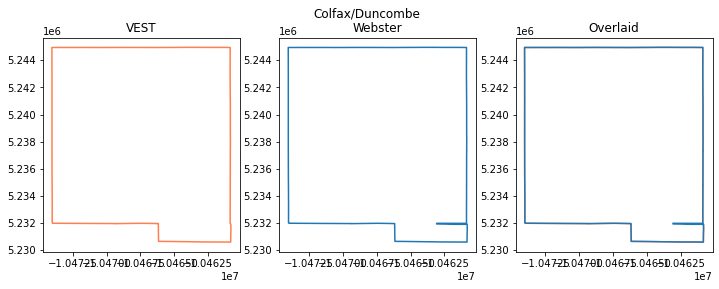

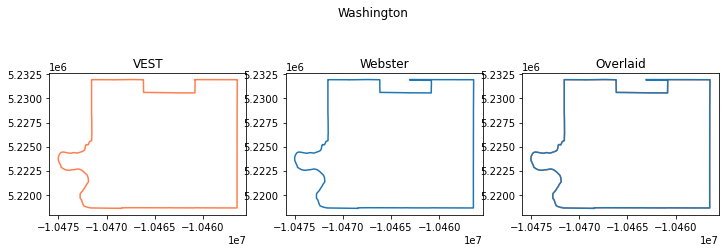

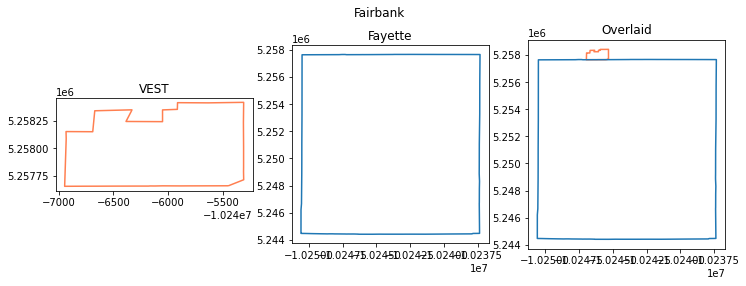

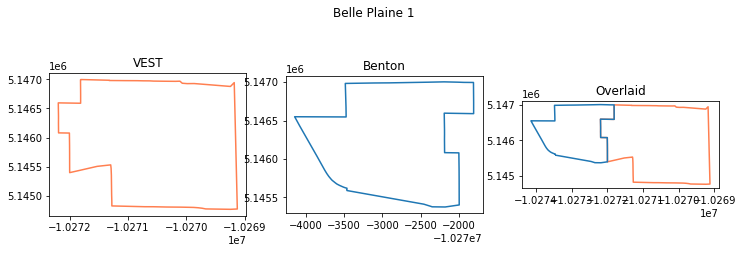

In [19]:
validated_counties = set()
county2incorrect = {}
problem_counties = set()

# we will convert this to a geodataframe at the end, but may not need to, because
# we will be joining to a geodataframe and will have to set the geometry
# to be different
shape_name_df = pd.DataFrame(columns=["VEST Name", "County", "geometry"])

for county in all_counties:
    
    if county in merged_counties or\
        county in census_counties or\
            county in local_counties:
        continue
        
    print(county)
    print('-' * 15)
    
    county_v = vest_df[vest_df["COUNTY"] == county].copy()
    county_sh = shape_df.copy()
    
    county2vest, invalid_county = assign_names_by_geoms(county_v, county_sh)
    
    # these are the idxs that contain the geoms that we want to match 
    # with the vest names and county
    idxs = [key[1][0] for key in county2vest]
    county_sh = county_sh.loc[idxs, :]
    
    county_sh, county_multiple = add_merge_column(county_sh, county2vest)
    county_incorrect = validate_assigned_geoms(county_v, county_sh, invalid_county)
    
    
    # unequal geoms and geom errors, respectively 
    if len(county_incorrect[0]) != 0 or len(county_incorrect[1]) != 0: 
        county2incorrect[county] = county_incorrect
        problem_counties.add(county)
    else:
        validated_counties.add(county)
    
    # there is some issue going on here. Maybe an offsetting issue?
    merge_data = pd.DataFrame(data = {"VEST Name" : county_sh["MERGE"], "geometry" : county_sh["geometry"]})
    merge_data["County"] = county
    shape_name_df = pd.concat([shape_name_df, merge_data], axis=0)
        
    print()



In [20]:
print(f"Number of counties validated first pass", len(validated_counties))

Number of counties validated first pass 80


#### Resolve apparent errors in Fayette, Benton county. 

,OBJECTID,OBJECTID_1,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,IDEAL_VALU,DEVIATION,House_Dist,Senate_Dis,Congressio,Shape_Leng,Shape_Le_1,Shape_Area,geometry
1408,1431,1412,9.0,0.224848,FAIRBANK,1.0,None,Fairbank,296.0,1.0,295.0,64.0,32,1,0.040798,0.040798,0.000064,"POLYGON ((-10245450.526 5257659.869, -10245584..."


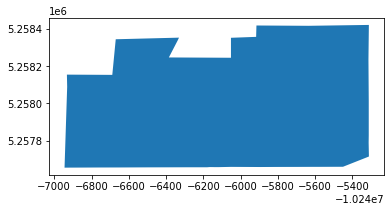

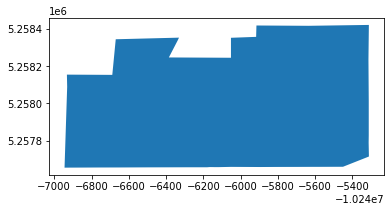

In [21]:
temp_v = vest_df[vest_df["COUNTY"] == "Fayette"].copy()
temp_v = temp_v[temp_v["NAME"] == "Fairbank"]
temp_v.plot()

fairbank_df = shape_df[shape_df["geometry"].geom_almost_equals(temp_v["geometry"].iloc[0])].copy()
display(fairbank_df)
fairbank_df.plot(figsize=(6,6))

# add VEST name, county, and geometry
temp = pd.DataFrame(data={"County" : ["Fayette"], "VEST Name" : ["Fairbank"], 
                    "geometry" : [fairbank_df["geometry"].iloc[0]]})
shape_name_df = pd.concat([shape_name_df, merge_data], axis=0, ignore_index=True)
# county2vest_idxs["Fayette"].append(fairbank_df.index.to_list()[0])

In [22]:
# Let's filter out Benton county and add it back in 
benton_df = vest_df[vest_df["COUNTY"] == "Benton"]
all_same = True
for i in range(len(benton_df["geometry"])):
    geom_v = benton_df["geometry"].iloc[i]
    name_v = benton_df["NAME"].iloc[i]
    equal_shape = shape_df[shape_df["geometry"].geom_almost_equals(geom_v)]
    
    geom_sh = equal_shape["geometry"].iloc[0]
    
    
    if len(equal_shape) != 1:
        all_same = False
        print(benton_df["NAME"].iloc[i])
        
    else:
        temp = pd.DataFrame(data={"County" : ["Benton"], "geometry" : [geom_sh], "VEST Name" : [name_v]})

shape_name_df = pd.concat([shape_name_df, temp], axis=0, ignore_index=True)
if all_same:
    print("All shapefiles accurate for Benton county.")

All shapefiles accurate for Benton county.


In [23]:
validated_counties.add("Webster")
validated_counties.add("Fayette")
validated_counties.add("Benton")

In [24]:
print(f"Still have {set(all_counties).difference(validated_counties).difference(census_counties).difference(merged_counties).difference(local_counties)} to examine.")

Still have set() to examine.


### Now, we will look at the counties that were taken from census data, contained merged precincts, and were downloaded from counties' local websites. 

#### Shapefiles that came from local county downloads:

Text(0.5, 1.0, 'Dallas county')

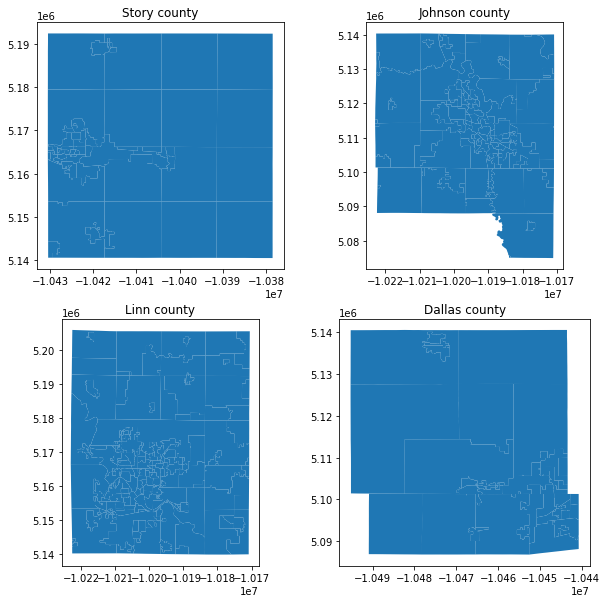

In [25]:
dallas_df = gp.read_file(DATA_PATH + "county_shapefiles/Dallas_data/VotingPrecincts.shp").to_crs(CRS)
johnson_df = gp.read_file(DATA_PATH + "county_shapefiles/Johnson_data/Precincts_ALL_2013.shp").to_crs(CRS)
linn_df = gp.read_file(DATA_PATH + "county_shapefiles/Linn_data/Voting_Precinct_Split.shp").to_crs(CRS)
story_df = gp.read_file(DATA_PATH + "county_shapefiles/Story_data/StoryCoPrecincts20210326.shp").to_crs(CRS)

fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax = ax.flatten()

story_df.plot(ax=ax[0])
johnson_df.plot(ax=ax[1])
linn_df.plot(ax=ax[2])
dallas_df.plot(ax=ax[3])

ax[0].set_title("Story county")
ax[1].set_title("Johnson county")
ax[2].set_title("Linn county")
ax[3].set_title("Dallas county")

#### Johnson


Geoms reported unequal for Coralville 02
Difference in area is 0.16 km^2

Geoms reported unequal for Scott Twp-West Branch
Difference in area is 0.36 km^2

Geoms reported unequal for Cedar Township
Difference in area is 0.27 km^2

Geoms reported unequal for Penn/East Lucas North
Difference in area is 0.16 km^2

Geoms reported unequal for Iowa City 24
Difference in area is 0.25 km^2

Geoms reported unequal for Oxford Township/Oxford
Difference in area is 0.13 km^2



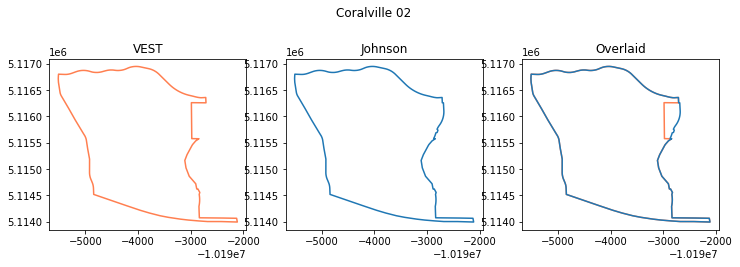

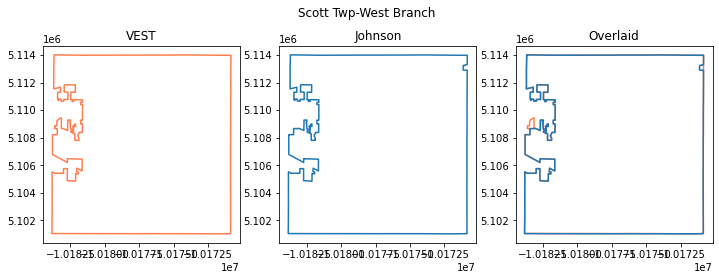

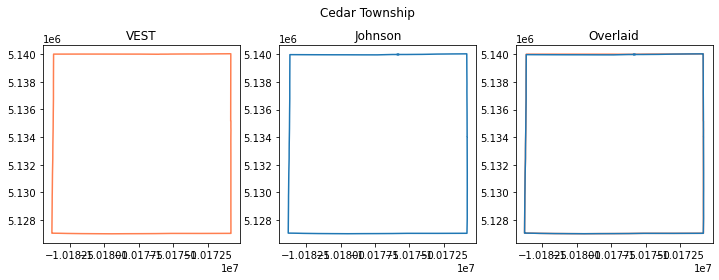

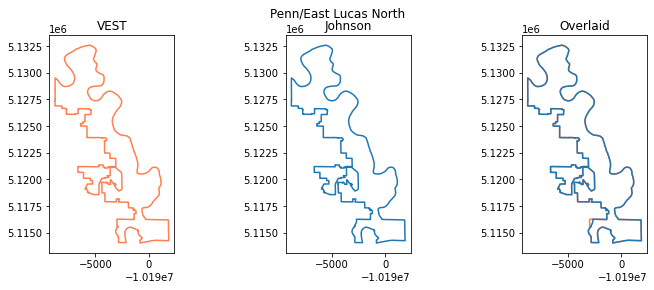

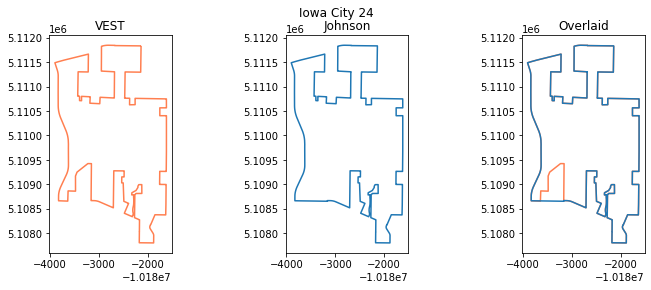

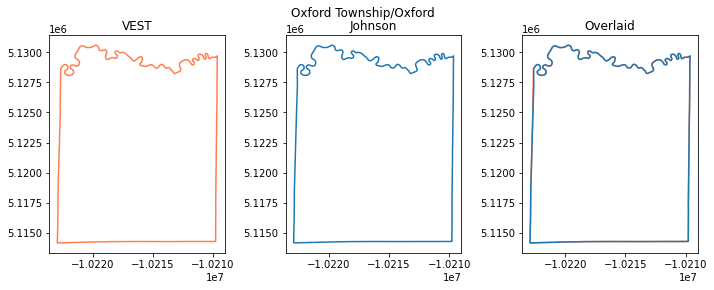

In [26]:
johnson_v = vest_df[vest_df["COUNTY"] == "Johnson"].copy()
johnson_df = johnson_df.to_crs(CRS)
johnson_df.rename(columns={"PRECINCT" : "NAME"}, inplace=True)

johnson2vest, invalid_johnson = assign_names_by_geoms(johnson_v, johnson_df)
johnson_df, johnson_multiple = add_merge_column(johnson_df, johnson2vest)
johnson_incorrect = validate_assigned_geoms(johnson_v, johnson_df, invalid_johnson)

In [27]:
# add johnson data to merge df
johnson_merge = pd.DataFrame(data={"VEST Name" : johnson_df["MERGE"], 
                                   "geometry" : johnson_df["geometry"]})
johnson_merge["County"] = "Johnson"
shape_name_df = pd.concat([shape_name_df, johnson_merge], axis=0, ignore_index=True)

#### Story


Geoms reported unequal for Story City
Difference in area is 0.41 km^2

Geoms reported unequal for Howard
Difference in area is 0.54 km^2



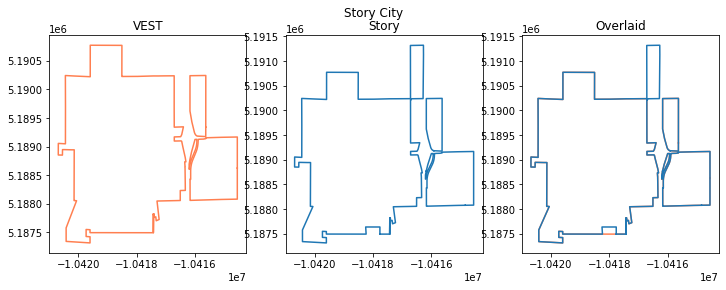

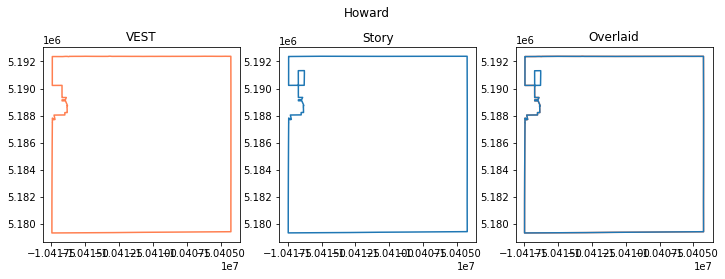

In [28]:
story_v = vest_df[vest_df["COUNTY"] == "Story"]
story_df.rename(columns={"PRECINCT" : "NAME"}, inplace=True)

story2vest, invalid_story = assign_names_by_geoms(story_v, story_df)
story_df, story_multiple = add_merge_column(story_df, story2vest)
story_incorrect = validate_assigned_geoms(story_v, story_df, invalid_story)

In [29]:
story_merge = pd.DataFrame(data={"VEST Name" : story_df["MERGE"], 
                                   "geometry" : story_df["geometry"]})
story_merge["County"] = "Story"
shape_name_df = pd.concat([shape_name_df, story_merge], axis=0, ignore_index=True)

#### Dallas


Geoms reported unequal for Waukee 2
Difference in area is 0.44 km^2

Geoms reported unequal for Van Meter
Difference in area is 2.6 km^2

Geoms reported unequal for Beaver/Des Moines
Difference in area is 0.4 km^2

Geoms reported unequal for De Soto
Difference in area is 0.41 km^2

Geoms reported unequal for Walnut/Grimes/Grant
Difference in area is 0.32 km^2

Geoms reported unequal for Adel 2 Precinct
Difference in area is 2.22 km^2



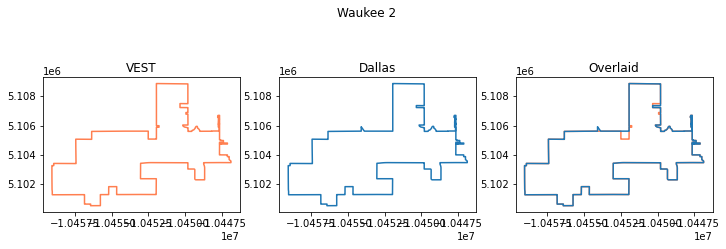

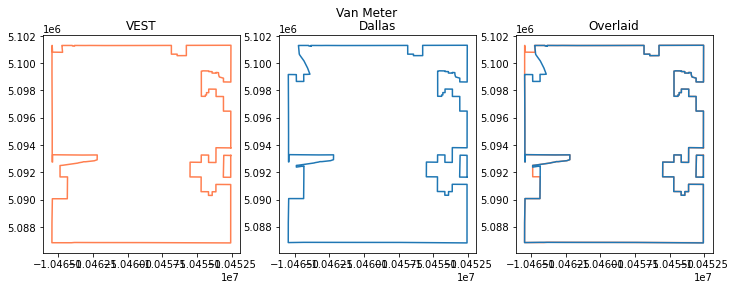

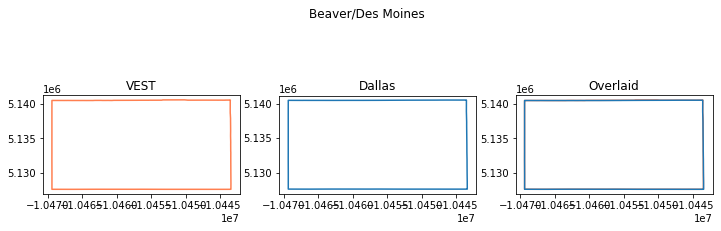

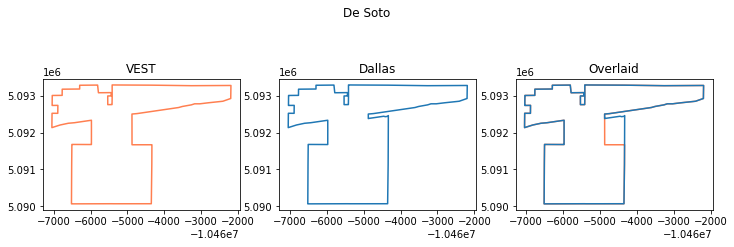

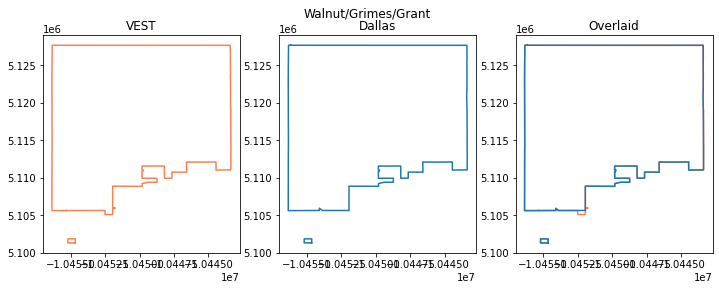

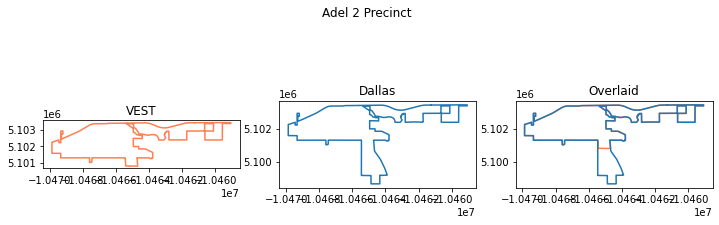

In [30]:
dallas_v = vest_df[vest_df["COUNTY"] == "Dallas"]
dallas_df = dallas_df.to_crs(CRS)
dallas_df.rename(columns={"name" : "NAME"}, inplace=True)

dallas2vest, invalid_dallas = assign_names_by_geoms(dallas_v, dallas_df, tolerance=2e-2)
dallas_df, dallas_multiple = add_merge_column(dallas_df, dallas2vest)
dallas_incorrect = validate_assigned_geoms(dallas_v, dallas_df, invalid_dallas)

In [31]:
dallas_merge = pd.DataFrame(data={"VEST Name" : dallas_df["MERGE"], 
                                   "geometry" : dallas_df["geometry"]})
dallas_merge["County"] = "Dallas"
shape_name_df = pd.concat([shape_name_df, dallas_merge], axis=0, ignore_index=True)

##### Adel 2 Precinct looks the most suspect, but the blue outline plotted is the shape of a single precinct in the locally downloaded file.

##### The differences between De Soto, Van Meter, and Waukee 2 seem to align, with missing parts of each precinct appearing in another. VEST likely made these changes after contacting the county. 

### Now let's verify the counties whose precinct shapes were taken from the census:

#### Pottawattamie

('COUNCIL BLUFFS PCT 1 & CARTER LAKE', (35,)) has multiple assignments: {'Council Bluffs 4', 'Council Bluffs 1', 'Carter Lake 2', 'Carter Lake 1'}

Geoms reported unequal for Council Bluffs 9
Difference in area is 0.3 km^2

Geoms reported unequal for Avoca
Difference in area is 4.04 km^2

Geoms reported unequal for Neola
Difference in area is 3.08 km^2

Geoms reported unequal for Oakland
Difference in area is 9.73 km^2

Exception thrown for geom_almost_equals on Carter Lake 1

Exception thrown for geom_almost_equals on Council Bluffs 1

Geoms reported unequal for Council Bluffs 4
Difference in area is 13.91 km^2

Geoms reported unequal for McClelland
Difference in area is 0.68 km^2

Geoms reported unequal for Garner
Difference in area is 0.18 km^2

Exception thrown for geom_almost_equals on Carter Lake 2



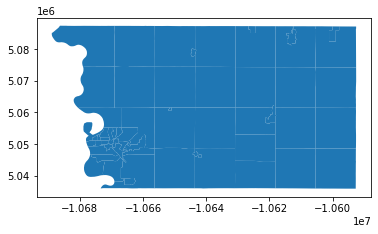

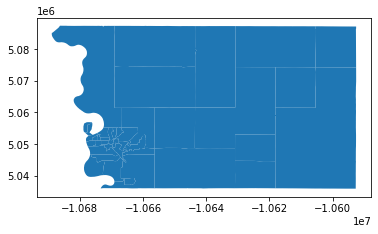

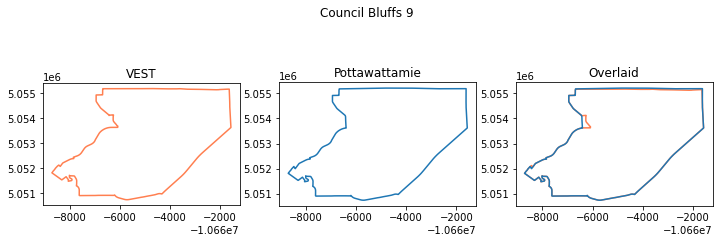

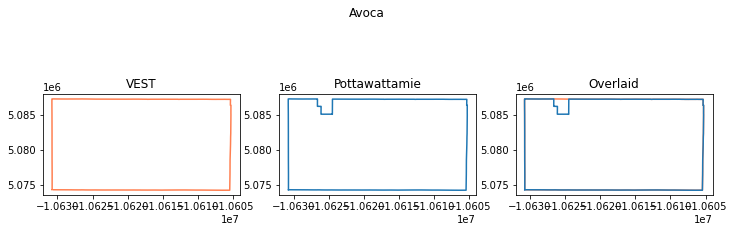

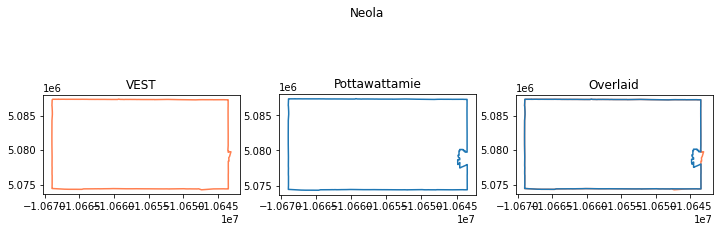

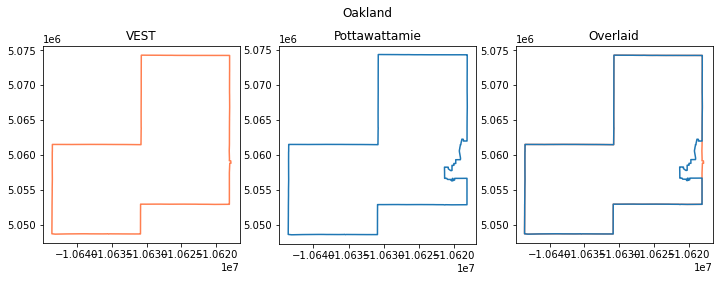

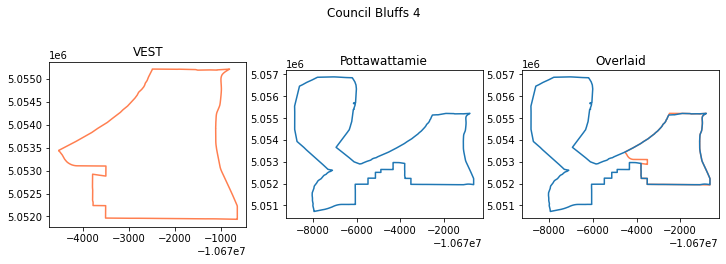

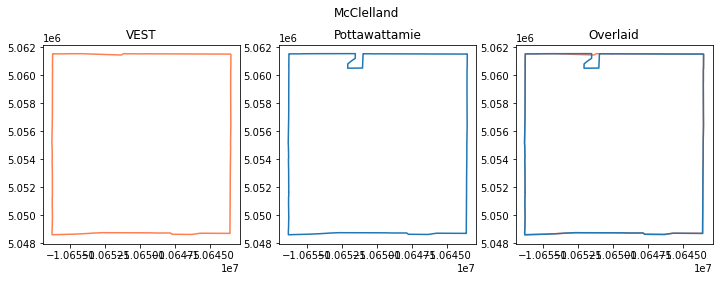

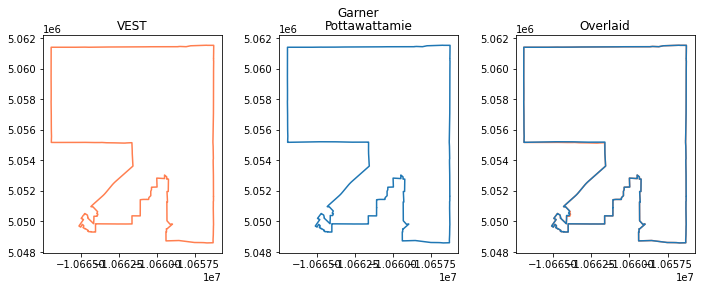

In [32]:
pottawattamie_v = vest_df[vest_df["COUNTY"] == "Pottawattamie"]
pottawattamie_df = gp.read_file("raw-from-source/census_counties/pottawattamie/PVS_19_v2_vtd_19155.shp").to_crs(CRS)\

pottawattamie_df.plot()
pottawattamie_v.plot()

pottawattamie2vest, pottawattamie_invalid = assign_names_by_geoms(pottawattamie_v, pottawattamie_df, tolerance=3e-2)
pottawattamie_df, pottawattamie_incorrect = add_merge_column(pottawattamie_df, pottawattamie2vest)
pottawattamie_incorrect = validate_assigned_geoms(pottawattamie_v, pottawattamie_df, pottawattamie_invalid)

In [33]:
pottawattamie_merge = pd.DataFrame(data={"VEST Name" : pottawattamie_df["MERGE"], 
                                   "geometry" : pottawattamie_df["geometry"]})
pottawattamie_merge["County"] = "Pottawattamie"
shape_name_df = pd.concat([shape_name_df, pottawattamie_merge], axis=0, ignore_index=True)

##### Council Bluffs 4 looks the way it does because the raw data has a precinct that includes a few VEST precincts and a lake, "Carter Lake". This leads to some shape mismatching in VEST NAMEs Carter Lake 2, Carter Lake 1, Council Bluffs 1, and Council Bluffs 4. 

##### Otherwise, Pottawammie is good! 

#### Marion

('PELLA IN MARION COUNTY W/LAKE PRAIRIE TWP PART', (3,)) has multiple assignments: {'Pella 4', 'Pella 2', 'Pella 1', 'Pella 3'}
('KNOXVILLE TWP', (5,)) has multiple assignments: {'Knoxville', 'Knoxville 1', 'Knoxville 2', 'Knoxville 4', 'Knoxville 3'}

Exception thrown for geom_almost_equals on Knoxville 4

Geoms reported unequal for Clay
Difference in area is 3.11 km^2

Geoms reported unequal for Knoxville
Difference in area is 21.26 km^2

Exception thrown for geom_almost_equals on Knoxville 2

Exception thrown for geom_almost_equals on Knoxville 1

Geoms reported unequal for Pella 4
Difference in area is 29.22 km^2

Exception thrown for geom_almost_equals on Pella 3

Exception thrown for geom_almost_equals on Pella 2

Exception thrown for geom_almost_equals on Pella 1

Exception thrown for geom_almost_equals on Knoxville 3



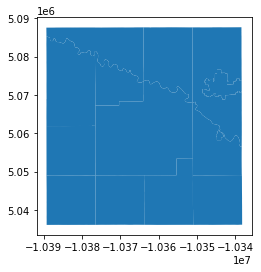

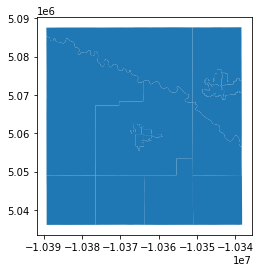

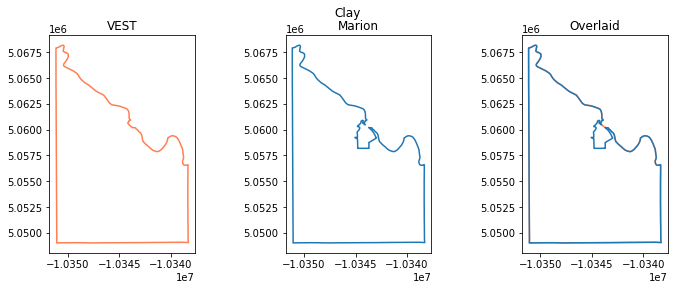

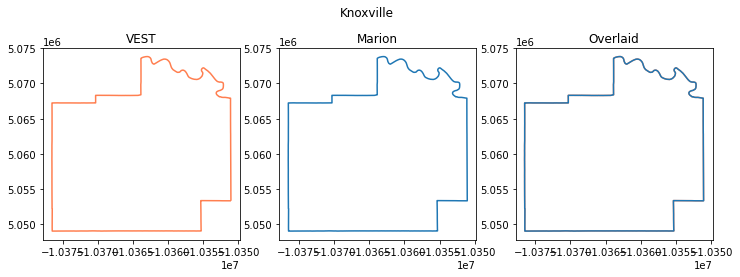

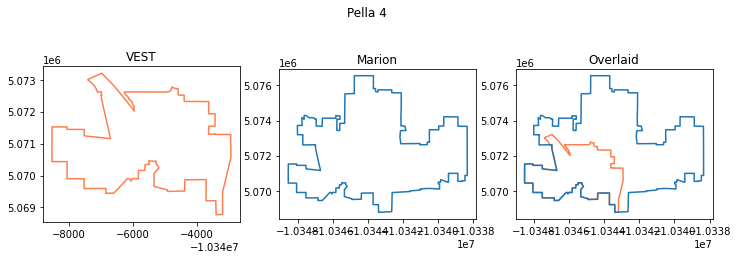

In [34]:
# marion
marion_v = vest_df[vest_df["COUNTY"] == "Marion"]
marion_df = gp.read_file("raw-from-source/census_counties/marion/PVS_19_v2_vtd_19125.shp").to_crs(CRS)

marion_df.plot()
marion_v.plot()

marion2vest, marion_invalid = assign_names_by_geoms(marion_v, marion_df)
marion_df, marion_incorrect= add_merge_column(marion_df, marion2vest)
marion_incorrect = validate_assigned_geoms(marion_v, marion_df, marion_invalid)

<AxesSubplot:>

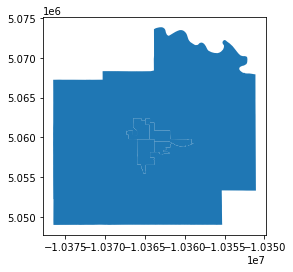

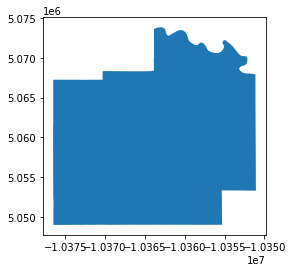

In [35]:
marion_v[marion_v["NAME"].isin({'Knoxville 4', 'Knoxville 3', 'Knoxville 2', 'Knoxville 1', 'Knoxville'})].plot()
marion_df[marion_df["NAME"] == 'KNOXVILLE TWP'].plot()

<AxesSubplot:>

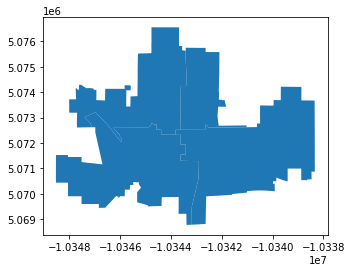

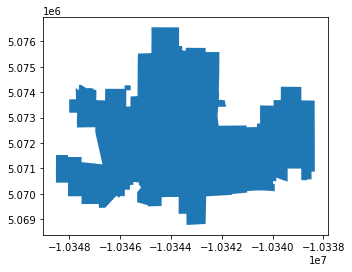

In [36]:
marion_v[marion_v["NAME"].isin({'Pella 3', 'Pella 2', 'Pella 1', 'Pella 4'})].plot()
marion_df[marion_df["NAME"] == 'PELLA IN MARION COUNTY W/LAKE PRAIRIE TWP PART'].plot()

In [37]:
marion_merge = pd.DataFrame(data={"VEST Name" : marion_df["MERGE"], 
                                   "geometry" : marion_df["geometry"]})
marion_merge["County"] = "Marion"
shape_name_df = pd.concat([shape_name_df, marion_merge], axis=0, ignore_index=True)

##### VEST takes two large precincts from the raw file, "PELLA IN MARION COUNTY W/LAKE PRAIRIE TWP PART" and "KNOXVILLE TWP" and split that into 4 and 5 counties, respectively. Otherwise, things are good! 

#### Muscatine


Geoms reported unequal for Muscatine 8
Difference in area is 0.25 km^2

Geoms reported unequal for Muscatine County Wilton City Precinct
Difference in area is 0.49 km^2

Geoms reported unequal for Muscatine 7
Difference in area is 0.25 km^2

Exception thrown for geom_almost_equals on West Liberty 2

Geoms reported unequal for Muscatine County West Liberty 1/ Wapsi Prec
Difference in area is 4.43 km^2

Geoms reported unequal for Muscatine County Moscow/ Wilton Precinct
Difference in area is 0.49 km^2

Geoms reported unequal for Muscatine County Fulton/ Montpelier Precinc
Difference in area is 0.73 km^2



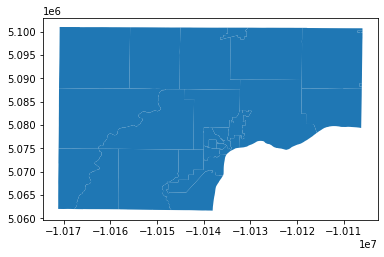

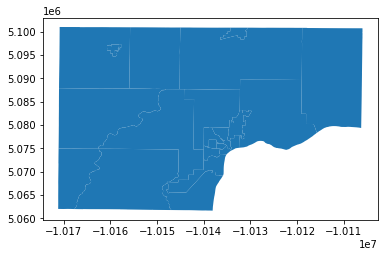

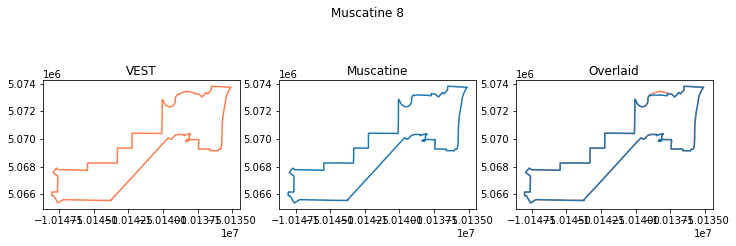

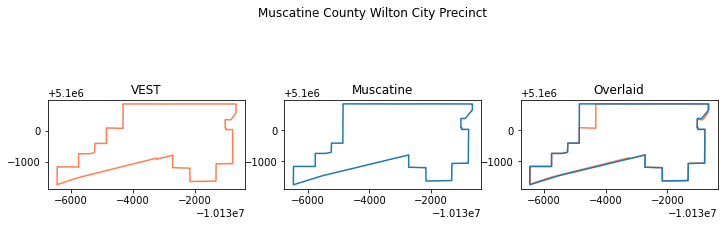

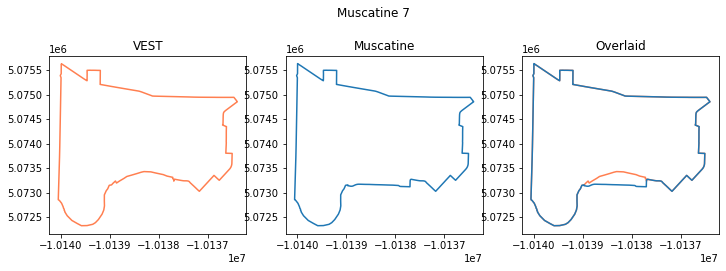

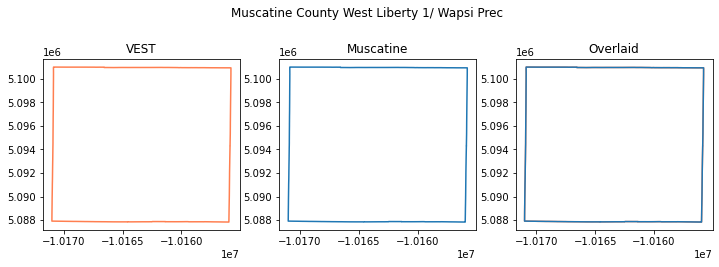

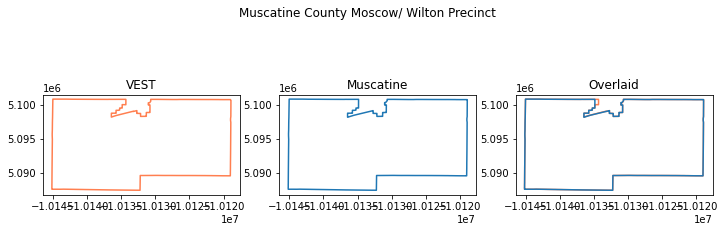

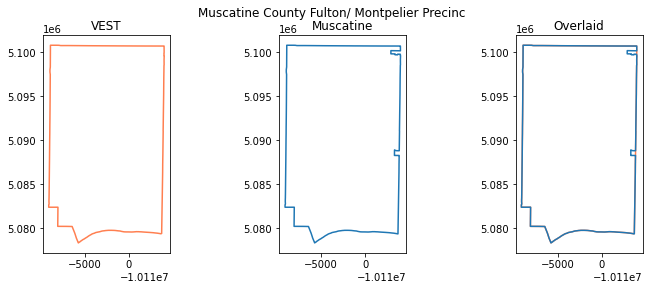

In [38]:
# Muscatine
muscatine_v = vest_df[vest_df["COUNTY"] == "Muscatine"]
muscatine_df = gp.read_file("raw-from-source/census_counties/muscatine/PVS_19_v2_vtd_19139.shp").to_crs(CRS)

muscatine_df.plot()
muscatine_v.plot()

muscatine2vest, muscatine_invalid = assign_names_by_geoms(muscatine_v, muscatine_df)
muscatine2vest[('WAPSINONOC TWP', (0,))] = {'Muscatine County West Liberty 1/ Wapsi Prec'}

muscatine_df, muscatine_incorrect = add_merge_column(muscatine_df, muscatine2vest)
muscatine_incorrect = validate_assigned_geoms(muscatine_v, muscatine_df, muscatine_invalid)

{'West Liberty 2'}


<AxesSubplot:>

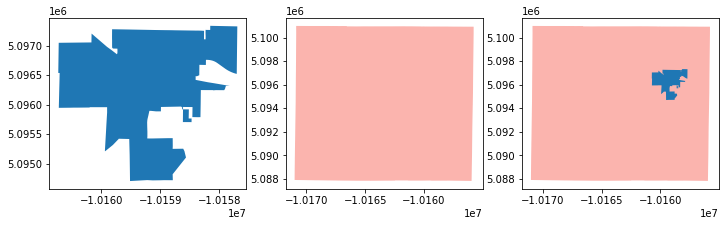

In [39]:
print(muscatine_incorrect[1])
west_liberty_2 = muscatine_v[muscatine_v["NAME"] == next(iter(muscatine_incorrect[1]))]
west_liberty_2_sh = muscatine_df[muscatine_df["geometry"].intersects(west_liberty_2["geometry"].iloc[0])]

fig, ax = plt.subplots(1, 3, figsize=(12,4))
west_liberty_2.plot(ax=ax[0])
west_liberty_2_sh.plot(ax=ax[1], cmap="Pastel1")
west_liberty_2_sh.plot(ax=ax[2], cmap="Pastel1")
west_liberty_2.plot(ax=ax[2])

#### West Liberty is a precinct that VEST created, doesn't appear to be present in the census shapefile. 

In [40]:
muscatine_df
muscatine_merge = pd.DataFrame(data={"VEST Name" : muscatine_df["MERGE"], 
                                   "geometry" : muscatine_df["geometry"]})
muscatine_merge["County"] = "Muscatine"
shape_name_df = pd.concat([shape_name_df, muscatine_merge], axis=0, ignore_index=True)

### Now let's do the counties that contained precincts that VEST merged. 

In [41]:
def display_unassigned(vest, shape, unassigned):
    """
    Used to visualize why unassigned VEST precincts did not
    have any corresponding raw shapefiles. 
    """
    for prc in unassigned:
        curr_v = vest[vest["NAME"] == prc].copy()  
        geom = curr_v["geometry"].iloc[0]
        
        intersects = shape[shape["geometry"].intersects(geom)].copy()
        
        fig, ax = plt.subplots()
        intersects.plot(ax=ax, cmap="Pastel1")
        try: 
            ax.plot(*geom.exterior.xy)
        except:
            for g in geom.geoms:
                ax.plot(*g.exterior.xy)

#### Tama

('Tama 13 - Howard/Toledo 1/Toledo Twp', (1494,)) has multiple assignments: {'Tama 13 - Howard/Toledo', 'Tama 14 - Toledo City'}

Geoms reported unequal for Tama 13 - Howard/Toledo
Difference in area is 2.29 km^2

Geoms reported unequal for Tama 14 - Toledo City
Difference in area is 2.29 km^2



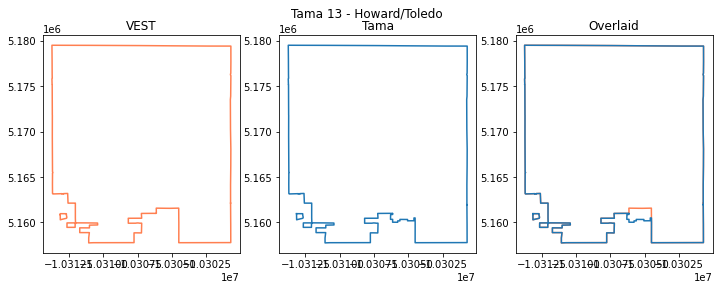

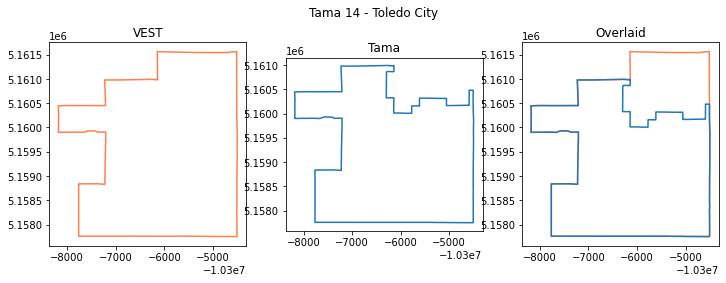

In [42]:
tama_v = vest_df[vest_df["COUNTY"] == "Tama"].copy()
tama_df = shape_df.copy()

tama2vest, tama_invalid = assign_names_by_geoms(tama_v, tama_df)
idxs = [key[1][0] for key in tama2vest]
tama_df = tama_df.loc[idxs, :]

tama_df, _ = add_merge_column(tama_df, tama2vest)
tama_incorrect = validate_assigned_geoms(tama_v, tama_df, tama_invalid)

display_unassigned(tama_v, tama_df, tama_incorrect[1])

In [43]:
tama_merge = pd.DataFrame(data={"VEST Name" : tama_df["MERGE"], 
                                   "geometry" : tama_df["geometry"]})
tama_merge["County"] = "Tama"
shape_name_df = pd.concat([shape_name_df, tama_merge], axis=0, ignore_index=True)

##### The only precinct that is off is VEST "Tama 14 - Toledo City", which when added to precinct "Tama 13 - Howard/Toledo 1/Toledo Twp", matched exactly. 

#### Black Hawk

In [44]:
black_hawk_v = vest_df[vest_df["COUNTY"] == "Black Hawk"].copy()
black_hawk_df = shape_df.copy()

black_hawk2vest, black_hawk_invalid = assign_names_by_geoms(black_hawk_v, black_hawk_df)

idxs = [key[1][0] for key in black_hawk2vest]
black_hawk_df = black_hawk_df.loc[idxs, :]

black_hawk_df, _ = add_merge_column(black_hawk_df, black_hawk2vest)
black_hawk_incorrect = validate_assigned_geoms(black_hawk_v, black_hawk_df, black_hawk_invalid)


All shapefiles match for Black Hawk county.


In [45]:
black_hawk_merge = pd.DataFrame(data={"VEST Name" : black_hawk_df["MERGE"], 
                                   "geometry" : black_hawk_df["geometry"]})
black_hawk_merge["County"] = "Black Hawk"
shape_name_df = pd.concat([shape_name_df, black_hawk_merge], axis=0, ignore_index=True)

#### Des Moines

In [46]:
# Des moines
des_moines_v = vest_df[vest_df["COUNTY"] == "Des Moines"].copy()
des_moines_df = shape_df.copy()

des_moines2vest, des_moines_invalid = assign_names_by_geoms(des_moines_v, des_moines_df)
idxs = [key[1][0] for key in des_moines2vest]
des_moines_df = des_moines_df.loc[idxs, :]
des_moines_df, _ = add_merge_column(des_moines_df, des_moines2vest)
des_moines_incorrect = validate_assigned_geoms(des_moines_v, des_moines_df, des_moines_invalid)


All shapefiles match for Des Moines county.


In [47]:
des_moines_merge = pd.DataFrame(data={"VEST Name" : des_moines_df["MERGE"], 
                                   "geometry" : des_moines_df["geometry"]})
des_moines_merge["County"] = "Des Moines"
shape_name_df = pd.concat([shape_name_df, des_moines_merge], axis=0, ignore_index=True)

#### Fremont

In [48]:
# Fremont
fremont_v = vest_df[vest_df["COUNTY"] == "Fremont"].copy()
fremont_outline = fremont_v.dissolve(by="COUNTY")["geometry"].iloc[0]
fremont_df = shape_df[(shape_df["geometry"].intersects(fremont_outline)) | (shape_df["geometry"].covered_by(fremont_outline))].copy()

fremont2vest, fremont_invalid = assign_names_by_geoms(fremont_v, fremont_df)

idxs = [key[1][0] for key in fremont2vest]
fremont_df = fremont_df.loc[idxs, :]

fremont_df, _ = add_merge_column(fremont_df, fremont2vest)
fremont_incorrect = validate_assigned_geoms(fremont_v, fremont_df, fremont_invalid)


All shapefiles match for Fremont county.


In [49]:
fremont_merge = pd.DataFrame(data={"VEST Name" : fremont_df["MERGE"], 
                                   "geometry" : fremont_df["geometry"]})
fremont_merge["County"] = "Fremont"
shape_name_df = pd.concat([shape_name_df, fremont_merge], axis=0, ignore_index=True)

#### Lee

In [50]:
# Lee
lee_v = vest_df[vest_df["COUNTY"] == "Lee"]
lee_df = shape_df.copy()

lee2vest, lee_invalid = assign_names_by_geoms(lee_v, lee_df)
idxs = [key[1][0] for key in lee2vest]
lee_df = lee_df.loc[idxs, :]
lee_df, _ = add_merge_column(lee_df, lee2vest)
lee_incorrect = validate_assigned_geoms(lee_v, lee_df, lee_invalid)


All shapefiles match for Lee county.


In [51]:
lee_merge = pd.DataFrame(data={"VEST Name" : lee_df["MERGE"], 
                                   "geometry" : lee_df["geometry"]})
lee_merge["County"] = "Lee"
shape_name_df = pd.concat([shape_name_df, lee_merge], axis=0, ignore_index=True)

#### Appanoose

In [52]:
# Appanoose
appanoose_v = vest_df[vest_df["COUNTY"] == "Appanoose"]
appanoose_df = shape_df.copy()

appanoose2vest, appanoose_invalid = assign_names_by_geoms(appanoose_v, appanoose_df)
idxs = [key[1][0] for key in appanoose2vest]
appanoose_df = appanoose_df.loc[idxs, :]
appanoose_df, _ = add_merge_column(appanoose_df, appanoose2vest)
appanoose_incorrect = validate_assigned_geoms(appanoose_v, appanoose_df, appanoose_invalid)


All shapefiles match for Appanoose county.


In [53]:
appanoose_merge = pd.DataFrame(data={"VEST Name" : appanoose_df["MERGE"], 
                                   "geometry" : appanoose_df["geometry"]})
appanoose_merge["County"] = "Appanoose"
shape_name_df = pd.concat([shape_name_df, appanoose_merge], axis=0, ignore_index=True)

In [54]:
shape_name_df["SHAPE_MERGE_ID"] = shape_name_df["County"] + " " + shape_name_df["VEST Name"]

## Summary:

#### Setting up the merge. 

In [55]:
print(len(shape_name_df[~shape_name_df["SHAPE_MERGE_ID"].isin(combined_election_results["SHAPE_MERGE_ID"])]))

missing = shape_name_df[~shape_name_df["SHAPE_MERGE_ID"].isin(combined_election_results["SHAPE_MERGE_ID"])]
missing_v = combined_election_results[~combined_election_results["SHAPE_MERGE_ID"].isin(shape_name_df["SHAPE_MERGE_ID"])]

print(missing["County"].value_counts())
print(missing_v["County_x"].value_counts())
print(len(shape_name_df))
print(len(election_name_df))
print(len(vest_df))


9
Pottawattamie    4
Johnson          2
Muscatine        2
Marion           1
Name: County, dtype: int64
Polk             177
Linn              86
Scott             63
Dubuque           35
Marion             7
Pottawattamie      3
Benton             1
Muscatine          1
Name: County_x, dtype: int64
1322
1677
1677


In [56]:
combined_election_results.head()

,SoS Name,VEST Name,County_x,ELECTION_MERGE_ID,SHAPE_MERGE_ID,Unnamed: 0,Precinct,G18GOVRREY,G18GOVDHUB,G18GOVLPOR,G18GOVOSIE,G18GOVOWRI,G18ATGDMIL,G18ATGLBAT,G18ATGOWRI,G18SOSRPAT,G18SOSDDEJ,G18SOSLOFE,G18SOSOWRI,G18TRERDAV,G18TREDFIT,G18TRELHIR,G18TREOWRI,G18AUDRMOS,G18AUDDSAN,G18AUDLPER,G18AUDOWRI,G18AGRRNAI,G18AGRDGAN,G18AGRLSTE,G18AGROWRI,County_y
0,Precinct No. 9 - NS Ballot #1,Dicksinon 9,Dickinson,Dickinson Precinct No. 9 - NS Ballot #1,Dickinson Dicksinon 9,8,Precinct No. 9 - NS Ballot #1,57,17,0,1,0,46,11,0,59,15,0,0,45,27,0,1,48,23,0,1,62,12,1,0,Dickinson
1,Precinct No. 7,Dickinson 7,Dickinson,Dickinson Precinct No. 7,Dickinson Dickinson 7,6,Precinct No. 7,62,33,5,0,0,59,24,1,63,35,1,0,51,44,2,0,57,39,1,0,74,24,2,0,Dickinson
2,Precinct No. 4 - NS Ballot #1,Dickinson 4,Dickinson,Dickinson Precinct No. 4 - NS Ballot #1,Dickinson Dickinson 4,3,Precinct No. 4 - NS Ballot #1,119,86,3,1,0,133,34,1,127,78,1,0,103,98,0,0,106,95,5,0,129,75,3,0,Dickinson
3,Precinct No. 6 - NS Ballot #1,Dickinson 6,Dickinson,Dickinson Precinct No. 6 - NS Ballot #1,Dickinson Dickinson 6,5,Precinct No. 6 - NS Ballot #1,139,83,2,4,0,143,43,3,139,82,5,0,114,106,5,0,118,105,5,0,149,76,4,0,Dickinson
4,Precinct No. 14 - S Ballot #1,Dickinson 14 - Spirit Lake West,Dickinson,Dickinson Precinct No. 14 - S Ballot #1,Dickinson Dickinson 14 - Spirit Lake West,13,Precinct No. 14 - S Ballot #1,243,166,5,2,0,267,71,3,248,156,1,0,219,188,6,0,228,178,5,0,254,151,5,0,Dickinson


In [57]:
recreated_vest = combined_election_results.merge(shape_name_df, how="left", on="SHAPE_MERGE_ID")
recreated_vest.head()

,SoS Name,VEST Name_x,County_x,ELECTION_MERGE_ID,SHAPE_MERGE_ID,Unnamed: 0,Precinct,G18GOVRREY,G18GOVDHUB,G18GOVLPOR,G18GOVOSIE,G18GOVOWRI,G18ATGDMIL,G18ATGLBAT,G18ATGOWRI,G18SOSRPAT,G18SOSDDEJ,G18SOSLOFE,G18SOSOWRI,G18TRERDAV,G18TREDFIT,G18TRELHIR,G18TREOWRI,G18AUDRMOS,G18AUDDSAN,G18AUDLPER,G18AUDOWRI,G18AGRRNAI,G18AGRDGAN,G18AGRLSTE,G18AGROWRI,County_y,VEST Name_y,County,geometry
0,Precinct No. 9 - NS Ballot #1,Dicksinon 9,Dickinson,Dickinson Precinct No. 9 - NS Ballot #1,Dickinson Dicksinon 9,8,Precinct No. 9 - NS Ballot #1,57,17,0,1,0,46,11,0,59,15,0,0,45,27,0,1,48,23,0,1,62,12,1,0,Dickinson,Dicksinon 9,Dickinson,POLYGON ((-10600549.57132463 5364242.647850607...
1,Precinct No. 7,Dickinson 7,Dickinson,Dickinson Precinct No. 7,Dickinson Dickinson 7,6,Precinct No. 7,62,33,5,0,0,59,24,1,63,35,1,0,51,44,2,0,57,39,1,0,74,24,2,0,Dickinson,Dickinson 7,Dickinson,"POLYGON ((-10579008.80463271 5350912.80768582,..."
2,Precinct No. 4 - NS Ballot #1,Dickinson 4,Dickinson,Dickinson Precinct No. 4 - NS Ballot #1,Dickinson Dickinson 4,3,Precinct No. 4 - NS Ballot #1,119,86,3,1,0,133,34,1,127,78,1,0,103,98,0,0,106,95,5,0,129,75,3,0,Dickinson,Dickinson 4,Dickinson,POLYGON ((-10578976.18801947 5388534.758675442...
3,Precinct No. 6 - NS Ballot #1,Dickinson 6,Dickinson,Dickinson Precinct No. 6 - NS Ballot #1,Dickinson Dickinson 6,5,Precinct No. 6 - NS Ballot #1,139,83,2,4,0,143,43,3,139,82,5,0,114,106,5,0,118,105,5,0,149,76,4,0,Dickinson,Dickinson 6,Dickinson,POLYGON ((-10565776.47937237 5364090.501447557...
4,Precinct No. 14 - S Ballot #1,Dickinson 14 - Spirit Lake West,Dickinson,Dickinson Precinct No. 14 - S Ballot #1,Dickinson Dickinson 14 - Spirit Lake West,13,Precinct No. 14 - S Ballot #1,243,166,5,2,0,267,71,3,248,156,1,0,219,188,6,0,228,178,5,0,254,151,5,0,Dickinson,Dickinson 14 - Spirit Lake West,Dickinson,"POLYGON ((-10590500.76090623 5376412.93990347,..."


In [58]:
vest_df["VEST_MERGE"] = vest_df["COUNTY"] + " " + vest_df["NAME"]
recreated_vest["VEST_MERGE"] = recreated_vest["County_x"] + " " + recreated_vest["VEST Name_x"]

print("Do we have any VEST IDs not present in recreated VEST?")
print(len(recreated_vest[~recreated_vest["VEST_MERGE"].isin(vest_df["VEST_MERGE"])]))
print()

print("Do we have any VEST IDs not present in VEST?")
print(len(vest_df[~vest_df["VEST_MERGE"].isin(recreated_vest["VEST_MERGE"])]))

Do we have any VEST IDs not present in recreated VEST?
0

Do we have any VEST IDs not present in VEST?
0


In [59]:
validate_df = vest_df.merge(recreated_vest, on="VEST_MERGE", how="outer")
validate_df.head()
columns=['G18GOVRREY', 'G18GOVDHUB', 'G18GOVLPOR', 'G18GOVOSIE', 'G18GOVOWRI', 
         'G18ATGDMIL', 'G18ATGLBAT', 'G18ATGOWRI', 'G18SOSRPAT', 'G18SOSDDEJ', 
         'G18SOSLOFE', 'G18SOSOWRI', 'G18TRERDAV', 'G18TREDFIT', 'G18TRELHIR', 
         'G18TREOWRI', 'G18AUDRMOS', 'G18AUDDSAN', 'G18AUDLPER', 'G18AUDOWRI', 
         'G18AGRRNAI', 'G18AGRDGAN', 'G18AGRLSTE', 'G18AGROWRI']


### Summary validation results:

#### First, validate election results. 

In [60]:
# Now we can begin some validation on real values, this is exciting. 
# Let's try to verify on a county wide basis 
def validater_row_vect(df, name_column, column_list, verbose=False):
    matching_rows = 0
    different_rows = 0
    
    county_join_cols = (df[name_column]).to_numpy()
    
    # it's because before, we were checking that a row was entirely consistent
    # here, we are double checking a lot
    # so, let's just keep one track of the rows that are messed up
    
    wrong_idxs = np.zeros(len(df))
    for i in column_list:
        left_data = df[i + "_x"].to_numpy()
        right_data = df[i + "_y"].to_numpy()
        
        local_idxs = np.where(left_data != right_data)
        wrong_idxs[local_idxs] = 1
        #print("Wrong idxs", wrong_idxs)
        
    # we are close, we get the same result, but are double adding lots of rows
    different_rows += np.sum(wrong_idxs)
    matching_rows += len(df) - different_rows
    
    diff_list = county_join_cols[np.where(wrong_idxs == 1)]
    diff_counties = list(set([county[:2] for county in diff_list]))
    
    if int(different_rows) != 0 or verbose:
        print("There are ", len(df.index)," total rows")
        print(f"{int(different_rows)} of these rows have election result differences")
        print(f"{int(matching_rows)} of these rows are the same")
        print(diff_list)
        print("")
        
    return (int(different_rows) == 0, diff_list)

print("Are election results the same?", validater_row_vect(validate_df, "VEST_MERGE", columns)[0])
print(len(validate_df))

Are election results the same? True
1686


#### Attempt to validate shapefile results, we are expecting some differences. 

In [61]:
vest_geoms = gp.GeoSeries(validate_df["geometry_x"], crs=CRS)
recreated_geoms = gp.GeoSeries(validate_df["geometry_y"], crs=CRS)

area_vest = vest_geoms.area
area_recreated = recreated_geoms.area

equal_idxs = vest_geoms.geom_almost_equals(recreated_geoms, align=False)
print(equal_idxs.value_counts())

area_vest = area_vest[~equal_idxs]
area_recreated = area_recreated[~equal_idxs]

print("The average different in area between reportedly mis-matched precincts:", np.round(np.mean(np.abs(area_vest - area_recreated) / 1e6),2))

# for which counties do we have errors?

True     1104
False     582
dtype: int64
The average different in area between reportedly mis-matched precincts: 1.35


#### While it may have been possible to validate some precinct shapefiles in Polk, Scott, Dubuque, and Linn county, we intentionally leave all out for the sake of simplicity. Let's filter them out of the incorrect precinct shapes now.

In [62]:
print("Which counties have errors?")

incorrect_validate_shapes = validate_df[~equal_idxs].copy()
incorrect_validate_shapes = incorrect_validate_shapes[~incorrect_validate_shapes["COUNTY"].isin(["Polk", "Scott", "Linn", "Dubuque"])]
print(incorrect_validate_shapes["COUNTY"][~equal_idxs].value_counts())

Which counties have errors?
Pottawattamie    40
Johnson          39
Dallas           34
Muscatine        23
Story            18
Marion           17
Page              4
Lee               4
Tama              4
Mahaska           3
Benton            3
Winneshiek        3
Des Moines        2
Jackson           2
Clinton           2
Fremont           2
Dickinson         2
Cedar             2
Lyon              2
Webster           2
Adams             2
Hamilton          2
Jasper            2
Humboldt          2
Black Hawk        1
Plymouth          1
Appanoose         1
Jones             1
Fayette           1
Name: COUNTY, dtype: int64


In [63]:
incorrect_area_vest = gp.GeoSeries(incorrect_validate_shapes["geometry_x"], crs=CRS).area.to_numpy()
incorrect_area_recreated = gp.GeoSeries(incorrect_validate_shapes["geometry_y"], crs=CRS).area.to_numpy()

area_difference = np.abs(incorrect_area_vest - incorrect_area_recreated) / 1e6

print(f"{np.round(len(area_difference[area_difference < .1]) / len(area_difference) * 100, 2)} percent of precincts have a difference in area of less than .1 km^2")
print(f"{np.round(len(area_difference[area_difference < 1]) / len(area_difference) * 100, 2)} percent of precincts have a difference in area of less than 1 km^2")

print("The precincts for which differences are larger have been displayed and highlighted previously in this notebook.")


77.83 percent of precincts have a difference in area of less than .1 km^2
88.24 percent of precincts have a difference in area of less than 1 km^2
The precincts for which differences are larger have been displayed and highlighted previously in this notebook.


#### The precincts and counties for which the difference in shapefile is larger than 1 km^2.

In [64]:
VERBOSE = False
incorrect_validate_shapes["VEST area"] = incorrect_area_vest
incorrect_validate_shapes["Shape area"] = incorrect_area_recreated

incorrect_validate_shapes["Area diff"] = np.round(area_difference,2)

area_diff= incorrect_validate_shapes[incorrect_validate_shapes["Area diff"] > 1].copy()

incorrect = []
for vest_name, county, area in zip(area_diff["NAME"], area_diff["COUNTY"], area_diff["Area diff"]):
    incorrect.append(county + ": " + vest_name + " " + str(area) + "km^2")
    
for prc in sorted(incorrect):
    print(prc)

Benton: Belle Plaine 1 3.07km^2
Dallas: Adel 2 Precinct 2.22km^2
Dallas: Van Meter 2.6km^2
Fayette: Fairbank 172.57km^2
Marion: Clay 3.11km^2
Marion: Knoxville 21.26km^2
Marion: Pella 4 29.22km^2
Muscatine: Muscatine County West Liberty 1/ Wapsi Prec 4.43km^2
Pottawattamie: Avoca 4.04km^2
Pottawattamie: Council Bluffs 4 13.91km^2
Pottawattamie: Neola 3.08km^2
Pottawattamie: Oakland 9.73km^2
Tama: Tama 13 - Howard/Toledo 2.29km^2
Tama: Tama 14 - Toledo City 2.29km^2


#### Here is the work to attempt to validate shapefile data for Linn, Dubuque, Polk, and Scott county. This work is a bit less clean, but will hopefully illustrate that recreating VEST's work for these counties was not as straightforward, and why we were ultimately unable to validate VEST's work. 

#### While there are precincts within each county's raw shapefile that do largely agree with VEST, the alterations of a sufficient number of precincts are enough for us to report the county as separate from the list of validated counties. 

#### Linn

Difference in area between Cedar Rapids 41: 23.91 km^2
Difference in area between Cedar Rapids 35: 9.65 km^2
Difference in area between Marion 09: 3.18 km^2
Difference in area between Cedar Rapids 20: 16.84 km^2
Difference in area between Cedar Rapids 03: 3.91 km^2
Difference in area between Marion Township: 473.18 km^2
Difference in area between Cedar Rapids 36: 31.49 km^2
Difference in area between Cedar Rapids 11: 11.96 km^2
Difference in area between Marion 10: 11.85 km^2
Difference in area between Robins: 224.49 km^2
Difference in area between Marion 02: 3.62 km^2
Difference in area between Marion 05: 6.83 km^2
Difference in area between Cedar Rapids 08: 4.35 km^2
Difference in area between Cedar Rapids 37: 5.73 km^2
Difference in area between Marion 06: 3.46 km^2
Difference in area between Cedar Rapids 39: 6.38 km^2
Difference in area between Marion 11: 24.64 km^2
Difference in area between Cedar Rapids 31: 0.0 km^2
Difference in area between Cedar Rapids 40: 23.54 km^2
Differenc

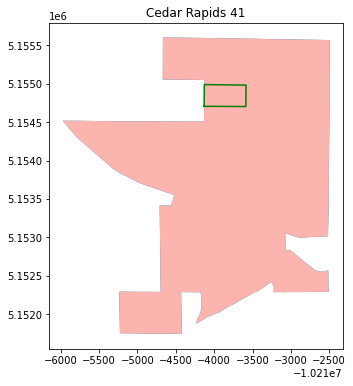

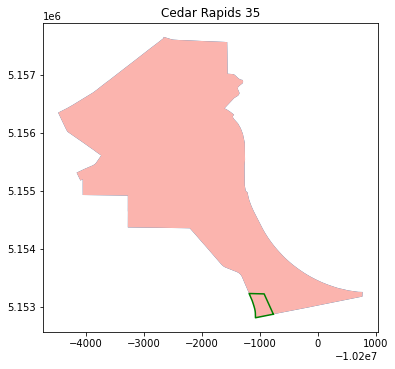

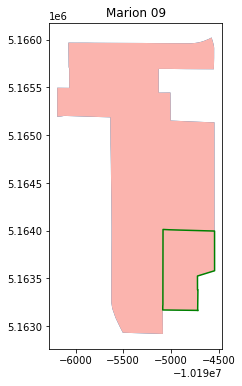

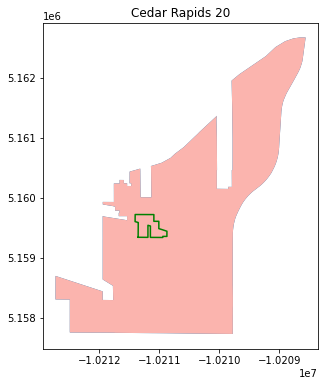

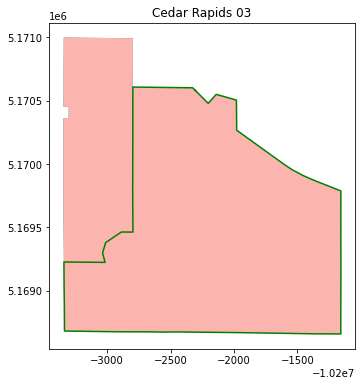

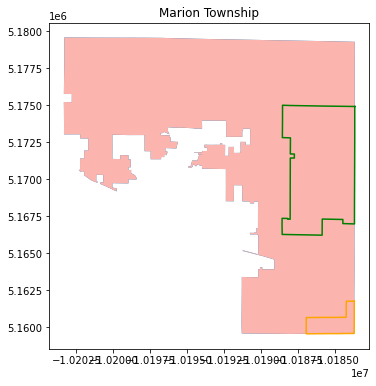

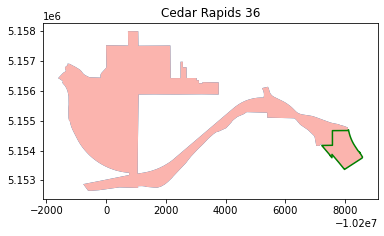

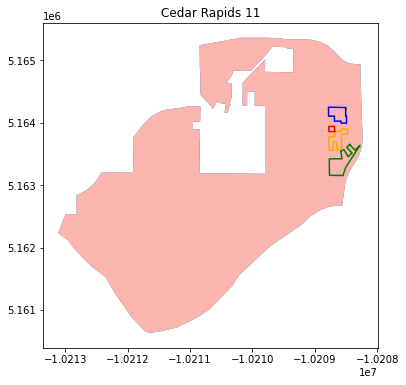

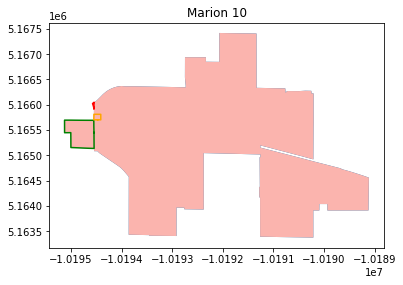

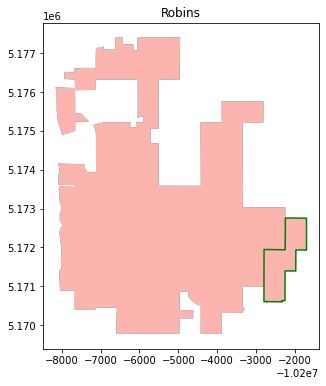

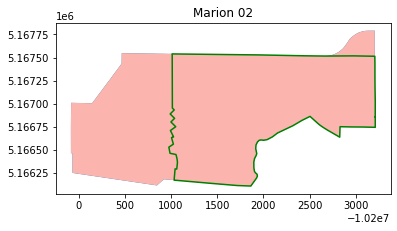

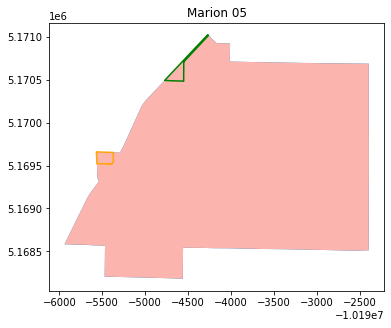

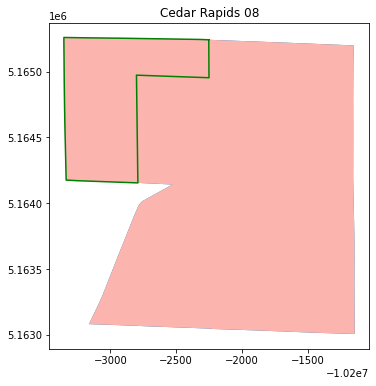

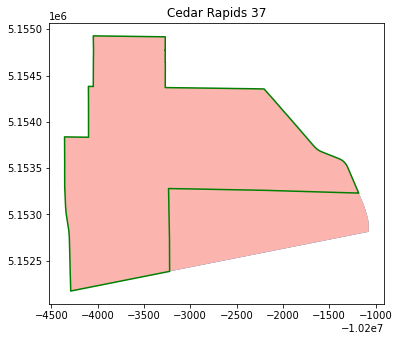

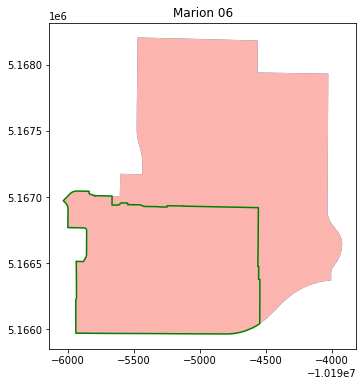

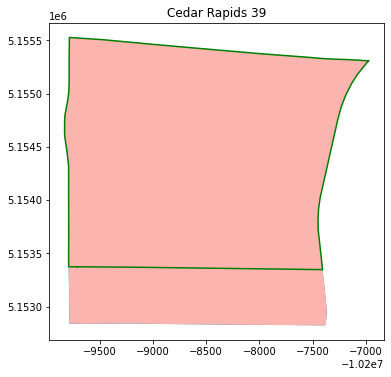

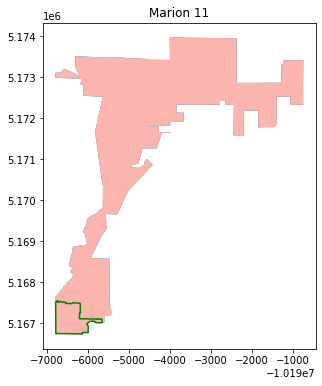

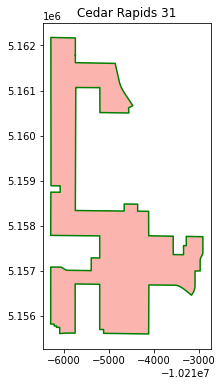

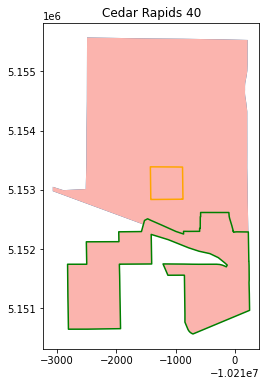

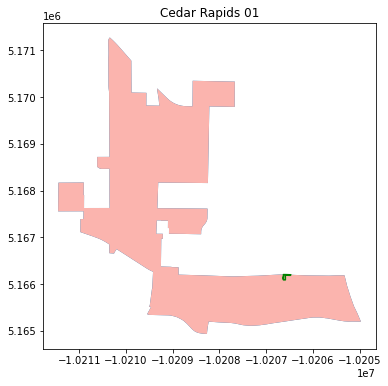

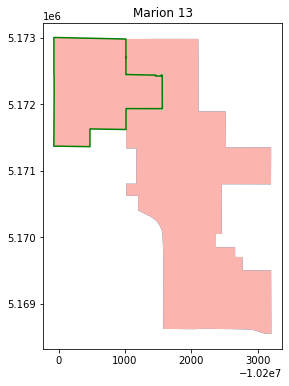

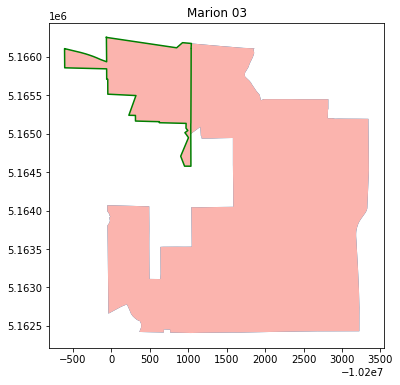

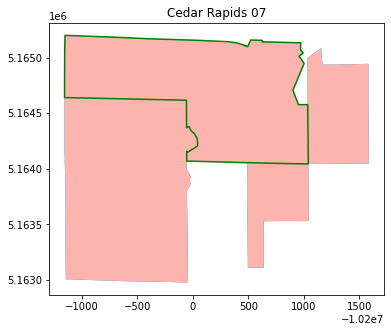

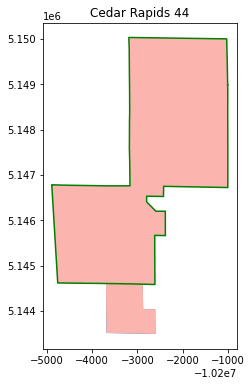

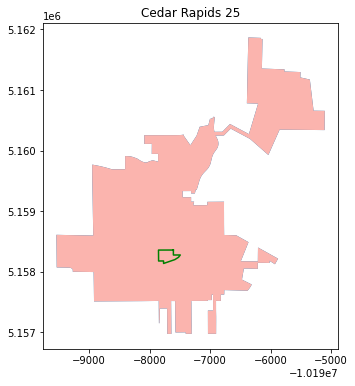

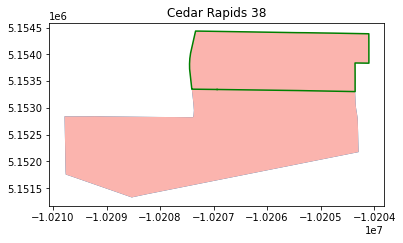

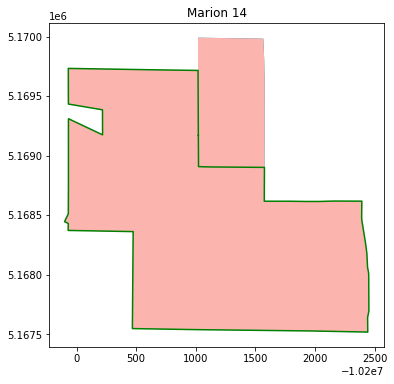

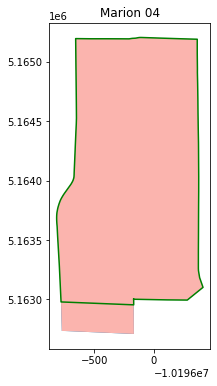

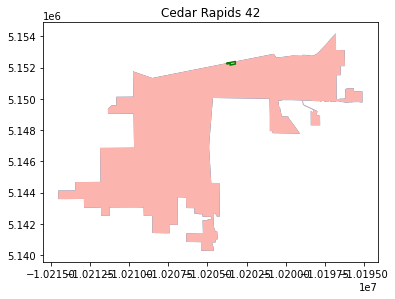

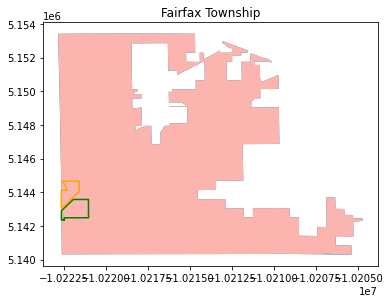

In [65]:
linn_v = vest_df[vest_df["COUNTY"] == "Linn"].copy()
linn_df = linn_df.to_crs(CRS)
linn_df.rename(columns={"PCT_LG_NAM" : "NAME"}, inplace=True)

unmatched_names_df = linn_df[~linn_df["NAME"].isin(linn_v["NAME"])]["NAME"]
unmatched_names_v = linn_v[~linn_v["NAME"].isin(linn_df["NAME"])]["NAME"]

name_assignment={}
for a, b in zip(sorted(unmatched_names_df.to_list()), sorted([val for val in unmatched_names_v.to_list() if val != "Fairfax Township"])):
    name_assignment[b] = a

linn_df["NAME"] = linn_df["NAME"].apply(lambda x: name_assignment[x] if x in name_assignment else x)
same_linn_v = linn_v[linn_v["NAME"].isin(linn_df["NAME"])].copy()

for i in range(len(linn_v)):
    geom = linn_v["geometry"].iloc[i]
    name = linn_v["NAME"].iloc[i]
    
    shape_prcs = linn_df[linn_df["NAME"] == name].copy()
    
    v_area = np.array(geom.area)
    sh_area = shape_prcs["geometry"].area.to_numpy()
    
    area_diff = np.sum(np.abs(v_area - sh_area)) / 1e6
    
    colors=["green", "orange", "red", "blue", "purple"]
    if area_diff > 1e-4:
        fig, ax = plt.subplots(figsize=(6,6))
        shape_prcs.plot(ax=ax)
        try:
            ax.plot(*shape_prcs["geometry"].iloc[0].exterior.xy, color=colors[0])
        except AttributeError:
            for idx, g in enumerate(shape_prcs["geometry"].iloc[0].geoms):
                ax.plot(*g.exterior.xy, color=colors[idx])
                
        linn_v[linn_v["NAME"] == name].plot(ax=ax, cmap="Pastel1")       
        ax.set_title(name)
        print(f"Difference in area between {name}: {np.round(area_diff,2)} km^2")

#### Scott

In [ ]:
# Scott
scott_v = vest_df[vest_df["COUNTY"] == "Scott"]
scott_df = gp.read_file("raw-from-source/census_counties/scott/PVS_19_v2_vtd_19163.shp").to_crs(CRS)

scott_df.plot()
scott_v.plot()

scott2vest, scott_invalid = assign_names_by_geoms(scott_v, scott_df)
scott2vest[('ALLENS GROVE TWP W/O DIXON', (1,))] = {"Allen's Grove"}
scott2vest[('BUTLER TWP', (8,))] = {"Parkview"}
scott2vest[('ELDRIDGE W/SHERIDAN TWP PART', (14,))] = {"Eldridge 2"}
scott2vest[('LE CLAIRE W/LE CLAIRE TWP PART', (16,))] = {"LeClaire 1"}

scott_df, scott_incorrect = add_merge_column(scott_df, scott2vest)
scott_incorrect = validate_assigned_geoms(scott_v, scott_df, scott_invalid)

for prc in scott_incorrect[1]:
    curr_v = scott_v[scott_v["NAME"] == prc].copy()
    geom = curr_v["geometry"].iloc[0]
    curr_sh = scott_df[scott_df["geometry"].intersects(geom)]
    
    fig, ax = plt.subplots()
    curr_sh.plot(ax=ax, cmap="Pastel1")
    ax.plot(*geom.exterior.xy)
    ax.set_title(prc)

#### Polk

In [ ]:
# Polk
polk_v = vest_df[vest_df["COUNTY"] == "Polk"].copy()
polk_df = gp.read_file("raw-from-source/census_counties/polk/PVS_19_v2_vtd_19153.shp").to_crs(CRS)

polk_df.plot()
polk_v.plot()

polk2vest, polk_invalid = assign_names_by_geoms(polk_v, polk_df)
idxs = [key[1][0] for key in polk2vest]
polk_df = polk_df.loc[idxs, :]

polk2vest[('POLK CITY', (14,))] = {'Polk County Polk City'}
polk2vest[('WEBSTER PCT 1', (23,))] = {'Polk County Webster 1'}
polk2vest[('ANKENY PCT 12', (164,))] = {'Ankeny Precinct 12'}
polk2vest[('DES MOINES PCT 71', (103,))] = {'Des Moines Precinct 71'}
polk2vest[('FOUR MILE PCT 1', (9,))] = {'Polk County Four Mile 1'}
polk2vest[('DES MOINES PCT 1', (39,))] = {'Des Moines Precinct 1'}
polk2vest[('DES MOINES PCT 29', (63,))] = {'Des Moines Precinct 29'}
polk2vest[('DES MOINES PCT 5', (48,))] = {'Polk County Saylor 2/ Des Moines Prct 5A'}
polk2vest[('ALLEN PCT 1 W/O CARLISLE', (35,))] = {'Polk County Allen 1'}
polk2vest[('DELAWARE PCT 1', (15,))] = {'Polk County Delaware 1'}
polk2vest[('SAYLOR PCT 1', (26,))] = {'Polk County Saylor 1'}
polk2vest[('URBANDALE PCT 4', (141,))] = {'Urbandale Precinct 4'}
polk2vest[('DES MOINES PCT 64', (77,))] = {'Des Moines Precinct 64'}
polk2vest[('JOHNSTON PCT 5', (148,))] = {'Des Moines Precinct 64'}
polk2vest[('GRIMES W/JEFFERSON TWP & WEBSTER TWP & URBANDALE PARTS', (21,))] = \
    polk2vest[('GRIMES W/JEFFERSON TWP & WEBSTER TWP & URBANDALE PARTS', (21,))].difference({"Grimes Precinct 3"})

polk_df, polk_incorrect = add_merge_column(polk_df, polk2vest)
polk_incorrect = validate_assigned_geoms(polk_v, polk_df, polk_invalid)

print(len(polk_incorrect[1]))
for prc in polk_incorrect[1]:
    curr_v = polk_v[polk_v["NAME"] == prc].copy()
    geom = curr_v["geometry"].iloc[0]
    curr_sh = polk_df[polk_df["geometry"].intersects(geom)]
    fig, ax = plt.subplots()
    curr_sh.plot(ax=ax, cmap="Pastel1")
    ax.plot(*geom.exterior.xy, color="limegreen")
    ax.set_title(f"VEST prc {prc}")

#### Dubuque

In [ ]:
dubuque_v = vest_df[vest_df["COUNTY"] == "Dubuque"]
dubuque_df = gp.read_file("raw-from-source/census_counties/dubuque/PVS_19_v2_vtd_19061.shp").to_crs(CRS)

# dubuque_df.plot()
# dubuque_v.plot()

print(dubuque_v.shape)
print(dubuque_df.shape)

print(sorted(dubuque_df["NAME"].value_counts().index.to_list()))
print(sorted(dubuque_v["NAME"].value_counts().index.to_list()))

# Dubuque
dubuque_v = vest_df[vest_df["COUNTY"] == "Dubuque"]
dubuque_df = gp.read_file("raw-from-source/census_counties/dubuque/PVS_19_v2_vtd_19061.shp").to_crs(CRS)

dubuque_df.plot()
dubuque_v.plot()

dubuque2vest, dubuque_invalid = assign_names_by_geoms(dubuque_v, dubuque_df)

# need to correct some things by hand
dubuque2vest[('DUBUQUE PCT 15', (36,))] = {'Dubuque 12'}
dubuque2vest[('TABLE MOUND TWP PART', (25,))] = {'Table Mound West - Dubuque precinct 45'}
dubuque2vest[('TAYLOR TWP W/O FARLEY', (17,))] = {'Iowa/Taylor - Dubuque precinct 41'}
dubuque2vest[('ASBURY', (5,))] = {'Asbury East - Dubuque precinct 31'}
dubuque2vest[('DYERSVILLE IN DUBUQUE COUNTY', (8,))] = {'Dyersville/Dodge - Dubuque precinct 39'}
dubuque2vest[('CENTER TWP PART W/O ASBURY & CENTRALIA', (4,))] = {'Center South/Vernon - Dubuque 34'}
dubuque2vest[('DODGE TWP W/O DYERSVILLE & FARLEY & WORTHINGTON', (7,))] = {'Dyersville/Dodge - Dubuque precinct 39'}
dubuque2vest[('CASCADE IN DUBUQUE COUNTY', (1,))] = {'Cascade/White Water - Dubuque 33'}
dubuque2vest[('RICKARDSVILLE', (31,))] = {'Jefferson/Peru - Dubuque 42'}
dubuque2vest[('WORTHINGTON', (32,))] = {'Dyersville/Dodge - Dubuque precinct 39'}
dubuque2vest[('CENTRALIA', (1,))] = {'Center South/Vernon - Dubuque 34'}
dubuque2vest[('ZWINGLE IN DUBUQUE COUNTY', (32,))] = {'Mosalem/Table Mound E/Wshngtn - Dubuque 43'}

dubuque_df, dubuque_incorrect = add_merge_column(dubuque_df, dubuque2vest)
dubuque_incorrect = validate_assigned_geoms(dubuque_v, dubuque_df, dubuque_invalid)

assigned_dubuque = {key[0] for key in dubuque2vest}
left_out = [prc for prc in dubuque_df["NAME"] if prc not in assigned_dubuque]

for name in left_out:
    curr = dubuque_df[dubuque_df["NAME"] == name].copy()
    geom = curr["geometry"].iloc[0]
    display(curr.head())
    fig, ax = plt.subplots()
    intersects = dubuque_df[dubuque_df["geometry"].intersects(geom)]
    intersects.plot(ax=ax, cmap="Pastel1")
    ax.plot(*geom.exterior.xy, color="limegreen")
    ax.set_title(name)